In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Mon Feb 19 14:38:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   30C    P8              21W / 215W |    614MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold4/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [10]:
from IConNet.nn.model import M13sinc as M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13sinc.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13sinc
description: SincNet with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: sinc
  learnable_bands: true
  learnable_windows: false
  shared_window: true
  window_func: hamming
  mel_resolution: 1
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
        

In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    # print(f'Mem before training: {torch.cuda.memory_allocated()}')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                        | 0.002061855670103093/10 [00:00<55:30, 333.13s/it]

Train Epoch: 1 [0/11481 (0%)]	Loss: 0.742010
Mem before-during-after: 539136 4324419584 21330432


  1%|█                                                                                                                        | 0.08453608247422686/10 [00:19<38:15, 231.56s/it]

Train Epoch: 1 [1280/11481 (11%)]	Loss: 0.385342
Mem before-during-after: 21330432 4332184576 21330432


  2%|██                                                                                                                       | 0.16701030927835056/10 [00:38<39:22, 240.30s/it]

Train Epoch: 1 [2560/11481 (22%)]	Loss: 0.402692
Mem before-during-after: 21330432 4332184576 21330432


  2%|███                                                                                                                      | 0.24948453608247398/10 [00:56<37:18, 229.54s/it]

Train Epoch: 1 [3840/11481 (34%)]	Loss: 0.050983
Mem before-during-after: 21330432 4332184576 21330432


  3%|████                                                                                                                      | 0.3319587628865974/10 [01:15<36:51, 228.71s/it]

Train Epoch: 1 [5120/11481 (45%)]	Loss: 0.964391
Mem before-during-after: 21330432 4332184576 21330432


  4%|█████                                                                                                                    | 0.41443298969072084/10 [01:34<37:45, 236.30s/it]

Train Epoch: 1 [6400/11481 (56%)]	Loss: 0.246365
Mem before-during-after: 21330432 4332184576 21330432


  5%|██████                                                                                                                   | 0.49690721649484426/10 [01:53<36:17, 229.15s/it]

Train Epoch: 1 [7680/11481 (67%)]	Loss: 0.293338
Mem before-during-after: 21330432 4332184576 21330432


  6%|███████                                                                                                                   | 0.5793814432989677/10 [02:11<36:17, 231.10s/it]

Train Epoch: 1 [8960/11481 (78%)]	Loss: 0.161160
Mem before-during-after: 21330432 4332184576 21330432


  7%|████████                                                                                                                  | 0.6618556701030911/10 [02:30<36:17, 233.20s/it]

Train Epoch: 1 [10240/11481 (89%)]	Loss: 0.705797
Mem before-during-after: 21330432 4332184576 21330432


 10%|████████████▏                                                                                                             | 0.9999999999999971/10 [03:15<15:16, 101.78s/it]


Test Epoch: 1	Accuracy: 3427/4064 (84%)



 10%|████████████▏                                                                                                             | 1.0020618556701002/10 [03:16<21:15, 141.77s/it]

Train Epoch: 2 [0/11481 (0%)]	Loss: 0.019650
Mem before-during-after: 21444096 4333847552 21330432


 11%|█████████████▏                                                                                                            | 1.0845360824742236/10 [03:35<34:35, 232.84s/it]

Train Epoch: 2 [1280/11481 (11%)]	Loss: 0.008145
Mem before-during-after: 21330432 4332184576 21330432


 12%|██████████████▎                                                                                                            | 1.167010309278347/10 [03:54<35:55, 243.99s/it]

Train Epoch: 2 [2560/11481 (22%)]	Loss: 0.494140
Mem before-during-after: 21330432 4332184576 21330432


 12%|███████████████▏                                                                                                          | 1.2494845360824705/10 [04:13<34:28, 236.33s/it]

Train Epoch: 2 [3840/11481 (34%)]	Loss: 0.099208
Mem before-during-after: 21330432 4332184576 21330432


 13%|████████████████▏                                                                                                         | 1.3319587628865939/10 [04:31<33:50, 234.28s/it]

Train Epoch: 2 [5120/11481 (45%)]	Loss: 0.966404
Mem before-during-after: 21330432 4332184576 21330432


 14%|█████████████████▎                                                                                                        | 1.4144329896907173/10 [04:50<33:37, 234.93s/it]

Train Epoch: 2 [6400/11481 (56%)]	Loss: 0.331934
Mem before-during-after: 21330432 4332184576 21330432


 15%|██████████████████▎                                                                                                       | 1.4969072164948407/10 [05:10<34:34, 243.97s/it]

Train Epoch: 2 [7680/11481 (67%)]	Loss: 0.230968
Mem before-during-after: 21330432 4332184576 21330432


 16%|███████████████████▎                                                                                                      | 1.5793814432989641/10 [05:29<34:12, 243.70s/it]

Train Epoch: 2 [8960/11481 (78%)]	Loss: 0.139268
Mem before-during-after: 21330432 4332184576 21330432


 17%|████████████████████▎                                                                                                     | 1.6618556701030875/10 [05:49<32:49, 236.21s/it]

Train Epoch: 2 [10240/11481 (89%)]	Loss: 0.896561
Mem before-during-after: 21330432 4332184576 21330432


 20%|████████████████████████▍                                                                                                 | 1.9999999999999936/10 [06:33<13:50, 103.80s/it]


Test Epoch: 2	Accuracy: 3496/4064 (85%)



 20%|████████████████████████▋                                                                                                  | 2.002061855670097/10 [06:34<18:47, 141.02s/it]

Train Epoch: 3 [0/11481 (0%)]	Loss: 0.016716
Mem before-during-after: 21444096 4333847552 21330432


 21%|█████████████████████████▍                                                                                                | 2.0845360824742203/10 [06:53<30:59, 234.90s/it]

Train Epoch: 3 [1280/11481 (11%)]	Loss: 0.002716
Mem before-during-after: 21330432 4332184576 21330432


 22%|██████████████████████████▍                                                                                               | 2.1670103092783437/10 [07:12<31:49, 243.74s/it]

Train Epoch: 3 [2560/11481 (22%)]	Loss: 0.361765
Mem before-during-after: 21330432 4332184576 21330432


 22%|███████████████████████████▋                                                                                               | 2.249484536082467/10 [07:31<30:39, 237.33s/it]

Train Epoch: 3 [3840/11481 (34%)]	Loss: 0.093981
Mem before-during-after: 21330432 4332184576 21330432


 23%|████████████████████████████▍                                                                                             | 2.3319587628865905/10 [07:50<30:05, 235.48s/it]

Train Epoch: 3 [5120/11481 (45%)]	Loss: 0.949539
Mem before-during-after: 21330432 4332184576 21330432


 24%|█████████████████████████████▋                                                                                             | 2.414432989690714/10 [08:09<29:39, 234.54s/it]

Train Epoch: 3 [6400/11481 (56%)]	Loss: 0.314985
Mem before-during-after: 21330432 4332184576 21330432


 25%|██████████████████████████████▍                                                                                           | 2.4969072164948374/10 [08:28<29:39, 237.12s/it]

Train Epoch: 3 [7680/11481 (67%)]	Loss: 0.250485
Mem before-during-after: 21330432 4332184576 21330432


 26%|███████████████████████████████▋                                                                                           | 2.579381443298961/10 [08:47<29:33, 239.01s/it]

Train Epoch: 3 [8960/11481 (78%)]	Loss: 0.117046
Mem before-during-after: 21330432 4332184576 21330432


 27%|████████████████████████████████▋                                                                                          | 2.661855670103084/10 [09:06<28:37, 234.07s/it]

Train Epoch: 3 [10240/11481 (89%)]	Loss: 1.007278
Mem before-during-after: 21330432 4332184576 21330432


 30%|████████████████████████████████████▌                                                                                     | 2.9999999999999902/10 [09:50<12:02, 103.20s/it]


Test Epoch: 3	Accuracy: 3509/4064 (86%)



 30%|████████████████████████████████████▋                                                                                     | 3.0020618556700933/10 [09:51<16:24, 140.70s/it]

Train Epoch: 4 [0/11481 (0%)]	Loss: 0.001673
Mem before-during-after: 21444096 4333847552 21330432


 31%|█████████████████████████████████████▋                                                                                    | 3.0845360824742167/10 [10:09<28:10, 244.50s/it]

Train Epoch: 4 [1280/11481 (11%)]	Loss: 0.028764
Mem before-during-after: 21330432 4332184576 21330432


 32%|███████████████████████████████████████▎                                                                                    | 3.16701030927834/10 [10:29<26:46, 235.07s/it]

Train Epoch: 4 [2560/11481 (22%)]	Loss: 0.529505
Mem before-during-after: 21330432 4332184576 21330432


 32%|███████████████████████████████████████▋                                                                                  | 3.2494845360824636/10 [10:47<26:22, 234.37s/it]

Train Epoch: 4 [3840/11481 (34%)]	Loss: 0.324321
Mem before-during-after: 21330432 4332184576 21330432


 33%|████████████████████████████████████████▉                                                                                  | 3.331958762886587/10 [11:07<26:21, 237.19s/it]

Train Epoch: 4 [5120/11481 (45%)]	Loss: 1.018823
Mem before-during-after: 21330432 4332184576 21330432


 34%|█████████████████████████████████████████▋                                                                                | 3.4144329896907104/10 [11:26<25:40, 233.91s/it]

Train Epoch: 4 [6400/11481 (56%)]	Loss: 0.312219
Mem before-during-after: 21330432 4332184576 21330432


 35%|███████████████████████████████████████████                                                                                | 3.496907216494834/10 [11:45<24:53, 229.60s/it]

Train Epoch: 4 [7680/11481 (67%)]	Loss: 0.173893
Mem before-during-after: 21330432 4332184576 21330432


 36%|███████████████████████████████████████████▋                                                                              | 3.5793814432989572/10 [12:03<24:41, 230.73s/it]

Train Epoch: 4 [8960/11481 (78%)]	Loss: 0.112499
Mem before-during-after: 21330432 4332184576 21330432


 37%|████████████████████████████████████████████▋                                                                             | 3.6618556701030807/10 [12:22<25:00, 236.67s/it]

Train Epoch: 4 [10240/11481 (89%)]	Loss: 1.838254
Mem before-during-after: 21330432 4332184576 21330432


 40%|████████████████████████████████████████████████▊                                                                         | 3.9999999999999867/10 [13:07<10:18, 103.02s/it]


Test Epoch: 4	Accuracy: 3521/4064 (86%)



 40%|█████████████████████████████████████████████████▋                                                                          | 4.00206185567009/10 [13:07<14:09, 141.62s/it]

Train Epoch: 5 [0/11481 (0%)]	Loss: 0.038853
Mem before-during-after: 21444096 4333847552 21330432


 41%|██████████████████████████████████████████████████▏                                                                        | 4.084536082474213/10 [13:26<23:38, 239.84s/it]

Train Epoch: 5 [1280/11481 (11%)]	Loss: 0.525787
Mem before-during-after: 21330432 4332184576 21330432


 42%|███████████████████████████████████████████████████▎                                                                       | 4.167010309278337/10 [13:45<23:13, 238.89s/it]

Train Epoch: 5 [2560/11481 (22%)]	Loss: 0.310571
Mem before-during-after: 21330432 4332184576 21330432


 42%|████████████████████████████████████████████████████▋                                                                       | 4.24948453608246/10 [14:05<22:50, 238.25s/it]

Train Epoch: 5 [3840/11481 (34%)]	Loss: 0.131772
Mem before-during-after: 21330432 4332184576 21330432


 43%|█████████████████████████████████████████████████████▎                                                                     | 4.331958762886583/10 [14:24<22:52, 242.23s/it]

Train Epoch: 5 [5120/11481 (45%)]	Loss: 1.206272
Mem before-during-after: 21330432 4332184576 21330432


 44%|██████████████████████████████████████████████████████▎                                                                    | 4.414432989690707/10 [14:43<21:58, 236.01s/it]

Train Epoch: 5 [6400/11481 (56%)]	Loss: 0.392953
Mem before-during-after: 21330432 4332184576 21330432


 45%|███████████████████████████████████████████████████████▊                                                                    | 4.49690721649483/10 [15:03<21:40, 236.36s/it]

Train Epoch: 5 [7680/11481 (67%)]	Loss: 0.173414
Mem before-during-after: 21330432 4332184576 21330432


 46%|████████████████████████████████████████████████████████▎                                                                  | 4.579381443298954/10 [15:22<21:39, 239.76s/it]

Train Epoch: 5 [8960/11481 (78%)]	Loss: 0.121190
Mem before-during-after: 21330432 4332184576 21330432


 47%|█████████████████████████████████████████████████████████▎                                                                 | 4.661855670103077/10 [15:41<21:04, 236.92s/it]

Train Epoch: 5 [10240/11481 (89%)]	Loss: 0.592355
Mem before-during-after: 21330432 4332184576 21330432


 50%|█████████████████████████████████████████████████████████████▍                                                             | 4.999999999999983/10 [16:26<08:50, 106.13s/it]


Test Epoch: 5	Accuracy: 3393/4064 (83%)



 50%|█████████████████████████████████████████████████████████████▌                                                             | 5.002061855670086/10 [16:26<11:51, 142.32s/it]

Train Epoch: 6 [0/11481 (0%)]	Loss: 0.008154
Mem before-during-after: 21444096 4333847552 21330432


 51%|███████████████████████████████████████████████████████████████                                                             | 5.08453608247421/10 [16:46<19:21, 236.21s/it]

Train Epoch: 6 [1280/11481 (11%)]	Loss: 0.142042
Mem before-during-after: 21330432 4332184576 21330432


 52%|███████████████████████████████████████████████████████████████▌                                                           | 5.167010309278333/10 [17:05<19:05, 237.05s/it]

Train Epoch: 6 [2560/11481 (22%)]	Loss: 0.415979
Mem before-during-after: 21330432 4332184576 21330432


 52%|████████████████████████████████████████████████████████████████                                                          | 5.2494845360824565/10 [17:24<19:24, 245.11s/it]

Train Epoch: 6 [3840/11481 (34%)]	Loss: 0.039928
Mem before-during-after: 21330432 4332184576 21330432


 53%|██████████████████████████████████████████████████████████████████                                                          | 5.33195876288658/10 [17:43<18:15, 234.74s/it]

Train Epoch: 6 [5120/11481 (45%)]	Loss: 1.622463
Mem before-during-after: 21330432 4332184576 21330432


 54%|██████████████████████████████████████████████████████████████████▌                                                        | 5.414432989690703/10 [18:01<17:34, 229.87s/it]

Train Epoch: 6 [6400/11481 (56%)]	Loss: 0.380060
Mem before-during-after: 21330432 4332184576 21330432


 55%|███████████████████████████████████████████████████████████████████▌                                                       | 5.496907216494827/10 [18:20<18:05, 240.99s/it]

Train Epoch: 6 [7680/11481 (67%)]	Loss: 0.233572
Mem before-during-after: 21330432 4332184576 21330432


 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 5.57938144329895/10 [18:39<17:06, 232.15s/it]

Train Epoch: 6 [8960/11481 (78%)]	Loss: 0.116998
Mem before-during-after: 21330432 4332184576 21330432


 57%|█████████████████████████████████████████████████████████████████████▋                                                     | 5.661855670103074/10 [18:58<16:38, 230.27s/it]

Train Epoch: 6 [10240/11481 (89%)]	Loss: 1.027704
Mem before-during-after: 21330432 4332184576 21330432


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 5.99999999999998/10 [19:43<06:51, 102.94s/it]


Test Epoch: 6	Accuracy: 3514/4064 (86%)



 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6.002061855670083/10 [19:43<09:25, 141.33s/it]

Train Epoch: 7 [0/11481 (0%)]	Loss: 0.024353
Mem before-during-after: 21444096 4333847552 21330432


 61%|██████████████████████████████████████████████████████████████████████████▊                                                | 6.084536082474206/10 [20:02<15:06, 231.54s/it]

Train Epoch: 7 [1280/11481 (11%)]	Loss: 0.014770
Mem before-during-after: 21330432 4332184576 21330432


 62%|███████████████████████████████████████████████████████████████████████████▏                                              | 6.1670103092783295/10 [20:21<14:48, 231.82s/it]

Train Epoch: 7 [2560/11481 (22%)]	Loss: 0.365955
Mem before-during-after: 21330432 4332184576 21330432


 62%|████████████████████████████████████████████████████████████████████████████▊                                              | 6.249484536082453/10 [20:39<14:41, 234.95s/it]

Train Epoch: 7 [3840/11481 (34%)]	Loss: 0.061883
Mem before-during-after: 21330432 4332184576 21330432


 63%|█████████████████████████████████████████████████████████████████████████████▉                                             | 6.331958762886576/10 [20:59<14:31, 237.71s/it]

Train Epoch: 7 [5120/11481 (45%)]	Loss: 1.128979
Mem before-during-after: 21330432 4332184576 21330432


 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 6.4144329896907/10 [21:18<14:10, 237.34s/it]

Train Epoch: 7 [6400/11481 (56%)]	Loss: 0.275485
Mem before-during-after: 21330432 4332184576 21330432


 65%|███████████████████████████████████████████████████████████████████████████████▉                                           | 6.496907216494823/10 [21:37<13:49, 236.76s/it]

Train Epoch: 7 [7680/11481 (67%)]	Loss: 0.133272
Mem before-during-after: 21330432 4332184576 21330432


 66%|████████████████████████████████████████████████████████████████████████████████▉                                          | 6.579381443298947/10 [21:56<13:45, 241.30s/it]

Train Epoch: 7 [8960/11481 (78%)]	Loss: 0.144027
Mem before-during-after: 21330432 4332184576 21330432


 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 6.66185567010307/10 [22:15<13:09, 236.51s/it]

Train Epoch: 7 [10240/11481 (89%)]	Loss: 0.872432
Mem before-during-after: 21330432 4332184576 21330432


 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 6.999999999999976/10 [23:01<05:27, 109.03s/it]


Test Epoch: 7	Accuracy: 3533/4064 (86%)



 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                    | 7.002061855670079/10 [23:01<07:22, 147.56s/it]

Train Epoch: 8 [0/11481 (0%)]	Loss: 0.060469
Mem before-during-after: 21444096 4333847552 21330432


 71%|██████████████████████████████████████████████████████████████████████████████████████▍                                   | 7.0845360824742025/10 [23:20<11:22, 234.13s/it]

Train Epoch: 8 [1280/11481 (11%)]	Loss: 0.015186
Mem before-during-after: 21330432 4332184576 21330432


 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7.167010309278326/10 [23:39<11:10, 236.76s/it]

Train Epoch: 8 [2560/11481 (22%)]	Loss: 0.459540
Mem before-during-after: 21330432 4332184576 21330432


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7.249484536082449/10 [23:58<10:29, 228.92s/it]

Train Epoch: 8 [3840/11481 (34%)]	Loss: 0.160261
Mem before-during-after: 21330432 4332184576 21330432


 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                | 7.331958762886573/10 [24:17<10:16, 230.97s/it]

Train Epoch: 8 [5120/11481 (45%)]	Loss: 1.222161
Mem before-during-after: 21330432 4332184576 21330432


 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                               | 7.414432989690696/10 [24:35<09:57, 231.07s/it]

Train Epoch: 8 [6400/11481 (56%)]	Loss: 0.256349
Mem before-during-after: 21330432 4332184576 21330432


 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7.49690721649482/10 [24:54<09:36, 230.25s/it]

Train Epoch: 8 [7680/11481 (67%)]	Loss: 0.205474
Mem before-during-after: 21330432 4332184576 21330432


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7.579381443298943/10 [25:13<09:28, 234.66s/it]

Train Epoch: 8 [8960/11481 (78%)]	Loss: 0.218653
Mem before-during-after: 21330432 4332184576 21330432


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7.6618556701030665/10 [25:33<09:21, 239.94s/it]

Train Epoch: 8 [10240/11481 (89%)]	Loss: 0.578776
Mem before-during-after: 21330432 4332184576 21330432


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 7.9999999999999725/10 [26:18<03:22, 101.31s/it]


Test Epoch: 8	Accuracy: 3552/4064 (87%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8.002061855670076/10 [26:18<04:37, 138.84s/it]

Train Epoch: 9 [0/11481 (0%)]	Loss: 0.035476
Mem before-during-after: 21444096 4333847552 21330432


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8.0845360824742/10 [26:37<07:26, 232.99s/it]

Train Epoch: 9 [1280/11481 (11%)]	Loss: 0.012592
Mem before-during-after: 21330432 4332184576 21330432


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8.167010309278323/10 [26:56<07:05, 232.21s/it]

Train Epoch: 9 [2560/11481 (22%)]	Loss: 0.365333
Mem before-during-after: 21330432 4332184576 21330432


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8.249484536082447/10 [27:15<06:50, 234.31s/it]

Train Epoch: 9 [3840/11481 (34%)]	Loss: 0.035045
Mem before-during-after: 21330432 4332184576 21330432


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8.33195876288657/10 [27:34<06:28, 232.62s/it]

Train Epoch: 9 [5120/11481 (45%)]	Loss: 0.914929
Mem before-during-after: 21330432 4332184576 21330432


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8.414432989690694/10 [27:53<06:15, 236.79s/it]

Train Epoch: 9 [6400/11481 (56%)]	Loss: 0.325784
Mem before-during-after: 21330432 4332184576 21330432


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8.496907216494817/10 [28:12<05:51, 234.05s/it]

Train Epoch: 9 [7680/11481 (67%)]	Loss: 0.112059
Mem before-during-after: 21330432 4332184576 21330432


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8.57938144329894/10 [28:31<05:35, 236.33s/it]

Train Epoch: 9 [8960/11481 (78%)]	Loss: 0.171224
Mem before-during-after: 21330432 4332184576 21330432


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8.661855670103064/10 [28:50<05:11, 232.98s/it]

Train Epoch: 9 [10240/11481 (89%)]	Loss: 0.852839
Mem before-during-after: 21330432 4332184576 21330432


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 8.99999999999997/10 [29:35<01:43, 103.63s/it]


Test Epoch: 9	Accuracy: 3256/4064 (80%)



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.002061855670073/10 [29:36<02:18, 139.11s/it]

Train Epoch: 10 [0/11481 (0%)]	Loss: 0.133125
Mem before-during-after: 21444096 4333847552 21330432


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9.084536082474196/10 [29:54<03:31, 230.61s/it]

Train Epoch: 10 [1280/11481 (11%)]	Loss: 0.009056
Mem before-during-after: 21330432 4332184576 21330432


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.16701030927832/10 [30:13<03:14, 233.58s/it]

Train Epoch: 10 [2560/11481 (22%)]	Loss: 0.351270
Mem before-during-after: 21330432 4332184576 21330432


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9.249484536082443/10 [30:32<02:55, 233.95s/it]

Train Epoch: 10 [3840/11481 (34%)]	Loss: 0.029226
Mem before-during-after: 21330432 4332184576 21330432


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9.331958762886567/10 [30:51<02:39, 238.35s/it]

Train Epoch: 10 [5120/11481 (45%)]	Loss: 0.911101
Mem before-during-after: 21330432 4332184576 21330432


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.41443298969069/10 [31:10<02:16, 233.50s/it]

Train Epoch: 10 [6400/11481 (56%)]	Loss: 0.266297
Mem before-during-after: 21330432 4332184576 21330432


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9.496907216494813/10 [31:28<01:57, 233.12s/it]

Train Epoch: 10 [7680/11481 (67%)]	Loss: 0.108206
Mem before-during-after: 21330432 4332184576 21330432


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9.579381443298937/10 [31:47<01:38, 235.27s/it]

Train Epoch: 10 [8960/11481 (78%)]	Loss: 0.150916
Mem before-during-after: 21330432 4332184576 21330432


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9.66185567010306/10 [32:06<01:19, 235.16s/it]

Train Epoch: 10 [10240/11481 (89%)]	Loss: 0.719096
Mem before-during-after: 21330432 4332184576 21330432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [32:51<00:00, 197.17s/it]


Test Epoch: 10	Accuracy: 3468/4064 (85%)



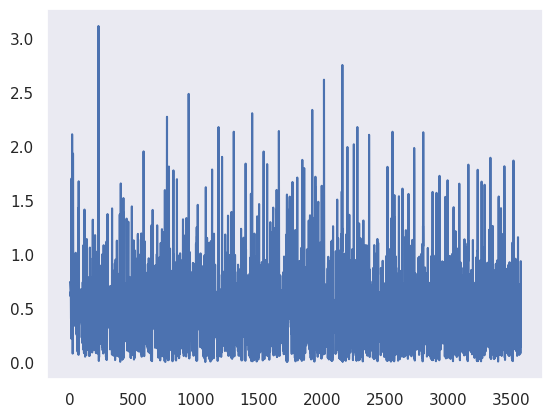

In [14]:
plt.plot(train_losses)

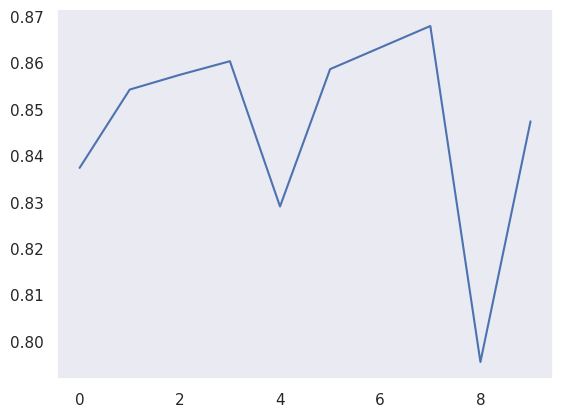

In [15]:
plt.plot(test_accuracy)

In [16]:
model_path = '../physio16k_fold4_m13sinc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3468/4064 (0.8533)
{'acc_detail': tensor([0.4483, 0.9800], device='cuda:0'),
 'acc_unweighted': tensor(0.7142, device='cuda:0'),
 'acc_weighted': tensor(0.8533, device='cuda:0'),
 'f1s': tensor(0.7517, device='cuda:0'),
 'f1s_detail': tensor([0.5929, 0.9106], device='cuda:0'),
 'precision_detail': tensor([0.8750, 0.8503], device='cuda:0'),
 'recall_detail': tensor([0.4483, 0.9800], device='cuda:0'),
 'rocauc': tensor([0.8967, 0.8967], device='cuda:0'),
 'uar': tensor(0.7142, device='cuda:0'),
 'wap': tensor(0.8562, device='cuda:0')}


tensor([[ 434,  534],
        [  62, 3034]], device='cuda:0')

In [19]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[ 0.0000],
        [ 0.1565],
        [ 0.0294],
        [-0.1687],
        [ 0.1131],
        [ 0.0495],
        [ 0.0610],
        [-0.0560],
        [-0.0395],
        [-0.0379],
        [-0.0401],
        [-0.0904],
        [ 0.1492],
        [ 0.1706],
        [-0.1282],
        [-0.0292],
        [-0.0406],
        [ 0.0849],
        [-0.0920],
        [ 0.0161],
        [ 0.1231],
        [-0.1167],
        [ 0.0980],
        [-0.0828],
        [ 0.1179],
        [ 0.0712],
        [-0.1262],
        [ 0.0213],
        [ 0.1202],
        [-0.0341],
        [ 0.0998],
        [-0.0532],
        [-0.0291],
        [ 0.0520],
        [-0.0411],
        [ 0.0065],
        [ 0.0774],
        [-0.0322],
        [ 0.0680],
        [-0.0235],
        [-0.1552],
        [-0.2017],
        [-0.0913],
        [ 0.1230],
        [ 0.0296],
        [-0.0480],
        [ 0.1273],
        [ 0.0115],
        [ 0.1842],
        [ 0.0236],
        [ 0

In [20]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000],
        [ 0.0166],
        [ 0.0200],
        [-0.0545],
        [ 0.0665],
        [ 0.0115],
        [ 0.0106],
        [-0.0663],
        [-0.1271],
        [-0.0308],
        [-0.0304],
        [-0.0240],
        [ 0.0155],
        [ 0.0588],
        [-0.0701],
        [-0.0071],
        [-0.0393],
        [ 0.0140],
        [-0.0458],
        [-0.1242],
        [-0.0721],
        [-0.1098],
        [ 0.0128],
        [-0.0233],
        [ 0.0452],
        [ 0.0089],
        [-0.0256],
        [-0.0110],
        [-0.0028],
        [ 0.0083],
        [-0.0011],
        [-0.0049],
        [-0.0619],
        [ 0.0084],
        [-0.0607],
        [ 0.0288],
        [ 0.0155],
        [-0.0402],
        [ 0.0127],
        [-0.0007],
        [-0.0721],
        [-0.0346],
        [-0.0199],
        [-0.0408],
        [ 0.0171],
        [-0.0367],
        [ 0.0108],
        [ 0.0566],
        [ 0.0069],
        [ 0.0191],
        [ 0.0644],
        [-0.0048],
        [-0.

[None, None]

(array([ 1.,  1.,  1.,  3.,  2.,  6.,  3.,  9.,  4.,  5.,  7.,  5.,  6.,
         9., 18.,  8.,  7.,  5.,  2.,  5.,  1.,  2.,  1.,  0.,  1.,  0.,
         3.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1.,  0.,
         1.]),
 array([-0.20171779, -0.18025231, -0.15878683, -0.13732135, -0.11585587,
        -0.09439038, -0.0729249 , -0.05145942, -0.02999394, -0.00852846,
         0.01293702,  0.0344025 ,  0.05586799,  0.07733347,  0.09879895,
         0.12026443,  0.14172992,  0.1631954 ,  0.18466088,  0.20612636,
         0.22759184,  0.24905732,  0.2705228 ,  0.29198828,  0.31345376,
         0.33491924,  0.35638472,  0.3778502 ,  0.39931569,  0.42078117,
         0.44224668,  0.46371216,  0.48517764,  0.50664312,  0.5281086 ,
         0.54957408,  0.57103956,  0.59250504,  0.61397052,  0.635436  ,
         0.65690148]),
 <BarContainer object of 40 artists>)

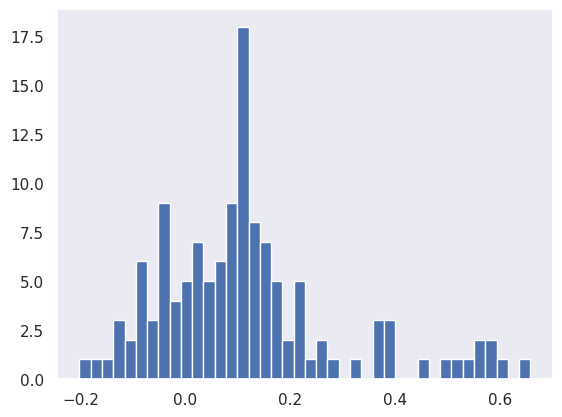

In [21]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,
         1.,  2., 12.,  6., 15., 15., 13., 17., 15., 10.,  3.,  7.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.]),
 array([-0.30007669, -0.28526238, -0.27044809, -0.25563377, -0.24081948,
        -0.22600518, -0.21119088, -0.19637658, -0.18156227, -0.16674797,
        -0.15193367, -0.13711935, -0.12230506, -0.10749076, -0.09267645,
        -0.07786214, -0.06304784, -0.04823354, -0.03341924, -0.01860493,
        -0.00379063,  0.01102367,  0.02583797,  0.04065228,  0.05546658,
         0.07028088,  0.08509519,  0.09990949,  0.11472379,  0.12953809,
         0.14435241,  0.15916671,  0.17398101,  0.18879531,  0.20360962,
         0.21842392,  0.23323822,  0.24805252,  0.26286682,  0.27768111,
         0.29249543]),
 <BarContainer object of 40 artists>)

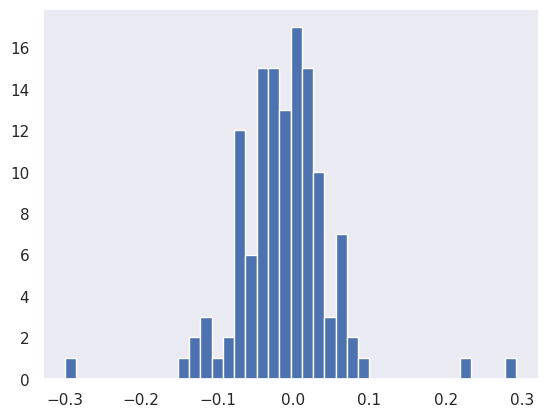

In [22]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  3.,  4.,  1.,  3.,  2.,  8.,  2.,  4.,  3.,
         4.,  5., 11.,  6.,  2.,  5.,  1.,  2.,  0.,  2.,  1.,  7.,  7.,
         8.,  9.,  6.,  5.,  3.,  1.,  3.,  0.,  2.,  2.,  3.,  0.,  0.,
         2.]),
 array([-0.21713081, -0.20683476, -0.19653872, -0.18624267, -0.17594662,
        -0.16565058, -0.15535451, -0.14505847, -0.13476242, -0.12446637,
        -0.11417033, -0.10387428, -0.09357823, -0.08328218, -0.07298613,
        -0.06269009, -0.05239404, -0.04209799, -0.03180194, -0.02150589,
        -0.01120985, -0.0009138 ,  0.00938225,  0.0196783 ,  0.02997435,
         0.0402704 ,  0.05056644,  0.06086249,  0.07115854,  0.08145459,
         0.09175064,  0.10204668,  0.11234273,  0.12263878,  0.13293482,
         0.14323089,  0.15352693,  0.16382298,  0.17411903,  0.18441507,
         0.19471112]),
 <BarContainer object of 40 artists>)

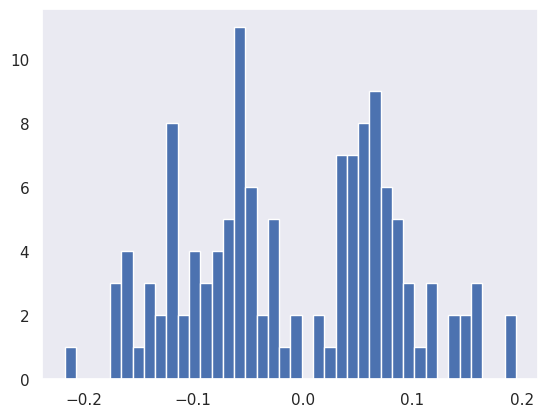

In [23]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  1.,  5.,  2.,  6., 12.,  8.,  8., 22., 19., 11.,
         3., 12.,  7.,  2.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,
         2.]),
 array([-0.24049541, -0.23042567, -0.22035593, -0.21028619, -0.20021644,
        -0.19014668, -0.18007694, -0.1700072 , -0.15993746, -0.14986771,
        -0.13979797, -0.12972823, -0.11965848, -0.10958873, -0.09951898,
        -0.08944924, -0.0793795 , -0.06930976, -0.05924001, -0.04917026,
        -0.03910052, -0.02903078, -0.01896103, -0.00889129,  0.00117846,
         0.0112482 ,  0.02131795,  0.03138769,  0.04145744,  0.05152718,
         0.06159693,  0.07166667,  0.08173642,  0.09180616,  0.1018759 ,
         0.11194565,  0.12201539,  0.13208514,  0.14215489,  0.15222463,
         0.16229437]),
 <BarContainer object of 40 artists>)

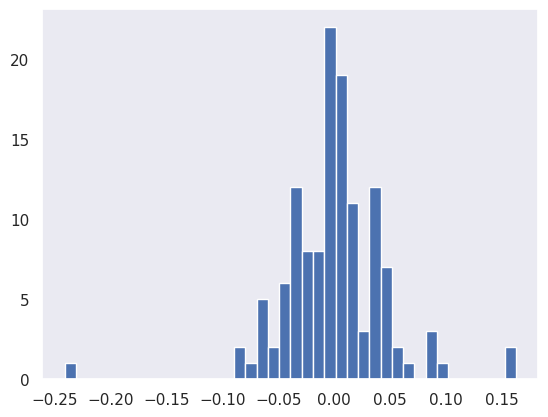

In [24]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

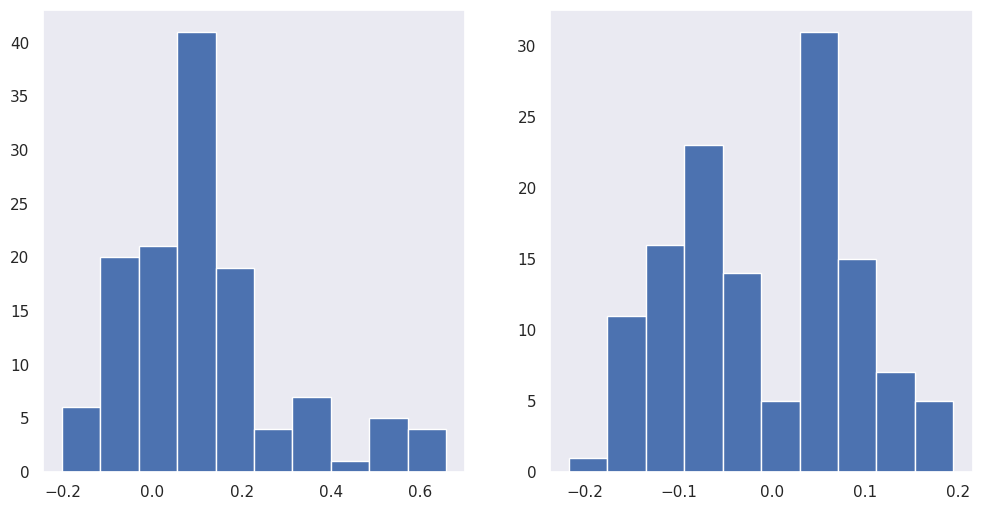

In [27]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

In [28]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0212, -0.2065,  0.1420,  ...,  0.1608,  0.2251,  0.1839],
        [ 0.1520, -0.1882,  0.2284,  ...,  0.2377, -0.0859,  0.0201],
        ...,
        [ 0.4683,  0.2689,  0.4730,  ...,  0.1648,  0.1561,  0.4594],
        [ 0.4875,  0.1887,  0.2106,  ...,  0.3427,  0.3264,  0.2364],
        [ 0.3576,  0.6140,  0.3535,  ...,  0.4236,  0.5007,  0.4877]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[ 0.4120,  0.2048,  0.3295,  ...,  0.2653,  0.1730,  0.2150],
        [ 0.0109,  0.1440, -0.1100,  ..., -0.1774,  0.0847, -0.1323],
        [ 0.0496,  0.1623,  0.2235,  ...,  0.1003, -0.1660, -0.0485],
        ...,
        [-0.4359, -0.0771,  0.2497,  ...,  0.1140, -0.1471,  0.2933],
        [ 0.4316,  0.1405,  0.0924,  ...,  0.1070,  0.1166, -0.1075],
        [-0.0548,  0.1058,  0.2538,  ...,  0.3565,  0.2399, -0.3339]],
       devi

downsample_factor: 8 => new_sample_rate: 2000


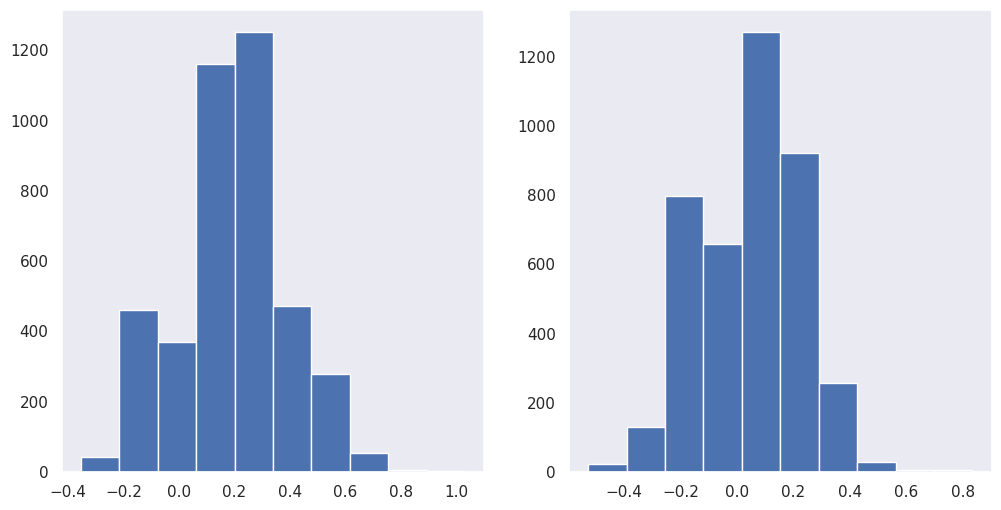

In [29]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

In [30]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                      | 0.002061855670103093/50 [00:00<3:17:32, 237.06s/it]

Train Epoch: 11 [0/11481 (0%)]	Loss: 0.037031
Mem before-during-after: 20657664 4333061120 21483008


  0%|▏                                                                                                                      | 0.08453608247422686/50 [00:20<3:33:30, 256.65s/it]

Train Epoch: 11 [1280/11481 (11%)]	Loss: 0.096893
Mem before-during-after: 21483008 4332337152 21483008


  0%|▍                                                                                                                      | 0.16701030927835056/50 [00:41<3:32:18, 255.62s/it]

Train Epoch: 11 [2560/11481 (22%)]	Loss: 0.438635
Mem before-during-after: 21483008 4332337152 21483008


  0%|▌                                                                                                                      | 0.24948453608247398/50 [01:01<3:29:37, 252.82s/it]

Train Epoch: 11 [3840/11481 (34%)]	Loss: 0.030565
Mem before-during-after: 21483008 4332337152 21483008


  1%|▊                                                                                                                       | 0.3319587628865974/50 [01:22<3:29:32, 253.13s/it]

Train Epoch: 11 [5120/11481 (45%)]	Loss: 0.735297
Mem before-during-after: 21483008 4332337152 21483008


  1%|▉                                                                                                                      | 0.41443298969072084/50 [01:43<3:32:50, 257.55s/it]

Train Epoch: 11 [6400/11481 (56%)]	Loss: 0.250217
Mem before-during-after: 21483008 4332337152 21483008


  1%|█▏                                                                                                                     | 0.49690721649484426/50 [02:03<3:33:46, 259.10s/it]

Train Epoch: 11 [7680/11481 (67%)]	Loss: 0.094701
Mem before-during-after: 21483008 4332337152 21483008


  1%|█▍                                                                                                                      | 0.5793814432989677/50 [02:23<3:28:11, 252.76s/it]

Train Epoch: 11 [8960/11481 (78%)]	Loss: 0.093689
Mem before-during-after: 21483008 4332337152 21483008


  1%|█▌                                                                                                                      | 0.6618556701030911/50 [02:44<3:28:19, 253.35s/it]

Train Epoch: 11 [10240/11481 (89%)]	Loss: 0.205038
Mem before-during-after: 21483008 4332337152 21483008


  2%|██▍                                                                                                                     | 0.9999999999999971/50 [03:33<1:31:49, 112.45s/it]


Test Epoch: 11	Accuracy: 3560/4064 (87%)



  2%|██▍                                                                                                                     | 1.0020618556701002/50 [03:33<2:03:27, 151.18s/it]

Train Epoch: 12 [0/11481 (0%)]	Loss: 0.054293
Mem before-during-after: 21596672 4334000128 21483008


  2%|██▌                                                                                                                     | 1.0845360824742236/50 [03:54<3:37:28, 266.75s/it]

Train Epoch: 12 [1280/11481 (11%)]	Loss: 0.017028
Mem before-during-after: 21483008 4332337152 21483008


  2%|██▊                                                                                                                      | 1.167010309278347/50 [04:14<3:27:26, 254.88s/it]

Train Epoch: 12 [2560/11481 (22%)]	Loss: 0.285876
Mem before-during-after: 21483008 4332337152 21483008


  2%|██▉                                                                                                                     | 1.2494845360824705/50 [04:35<3:28:27, 256.57s/it]

Train Epoch: 12 [3840/11481 (34%)]	Loss: 0.004744
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▏                                                                                                                    | 1.3319587628865939/50 [04:55<3:26:13, 254.25s/it]

Train Epoch: 12 [5120/11481 (45%)]	Loss: 0.692617
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▍                                                                                                                    | 1.4144329896907173/50 [05:16<3:22:29, 250.07s/it]

Train Epoch: 12 [6400/11481 (56%)]	Loss: 0.201152
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▌                                                                                                                    | 1.4969072164948407/50 [05:36<3:23:37, 251.90s/it]

Train Epoch: 12 [7680/11481 (67%)]	Loss: 0.074582
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▊                                                                                                                    | 1.5793814432989641/50 [05:57<3:21:11, 249.30s/it]

Train Epoch: 12 [8960/11481 (78%)]	Loss: 0.087197
Mem before-during-after: 21483008 4332337152 21483008


  3%|███▉                                                                                                                    | 1.6618556701030875/50 [06:16<3:18:56, 246.93s/it]

Train Epoch: 12 [10240/11481 (89%)]	Loss: 0.493886
Mem before-during-after: 21483008 4332337152 21483008


  4%|████▊                                                                                                                   | 1.9999999999999936/50 [07:05<1:29:12, 111.51s/it]


Test Epoch: 12	Accuracy: 3580/4064 (87%)



  4%|████▊                                                                                                                    | 2.002061855670097/50 [07:05<1:59:17, 149.11s/it]

Train Epoch: 13 [0/11481 (0%)]	Loss: 0.035424
Mem before-during-after: 21596672 4334000128 21483008


  4%|█████                                                                                                                   | 2.0845360824742203/50 [07:25<3:21:05, 251.80s/it]

Train Epoch: 13 [1280/11481 (11%)]	Loss: 0.030100
Mem before-during-after: 21483008 4332337152 21483008


  4%|█████▏                                                                                                                  | 2.1670103092783437/50 [07:46<3:22:43, 254.30s/it]

Train Epoch: 13 [2560/11481 (22%)]	Loss: 0.199875
Mem before-during-after: 21483008 4332337152 21483008


  4%|█████▍                                                                                                                   | 2.249484536082467/50 [08:06<3:21:28, 253.16s/it]

Train Epoch: 13 [3840/11481 (34%)]	Loss: 0.007856
Mem before-during-after: 21483008 4332337152 21483008


  5%|█████▌                                                                                                                  | 2.3319587628865905/50 [08:27<3:27:19, 260.96s/it]

Train Epoch: 13 [5120/11481 (45%)]	Loss: 0.812270
Mem before-during-after: 21483008 4332337152 21483008


  5%|█████▊                                                                                                                   | 2.414432989690714/50 [08:47<3:22:11, 254.94s/it]

Train Epoch: 13 [6400/11481 (56%)]	Loss: 0.172510
Mem before-during-after: 21483008 4332337152 21483008


  5%|█████▉                                                                                                                  | 2.4969072164948374/50 [09:08<3:19:14, 251.66s/it]

Train Epoch: 13 [7680/11481 (67%)]	Loss: 0.098996
Mem before-during-after: 21483008 4332337152 21483008


  5%|██████▏                                                                                                                  | 2.579381443298961/50 [09:28<3:15:41, 247.60s/it]

Train Epoch: 13 [8960/11481 (78%)]	Loss: 0.089928
Mem before-during-after: 21483008 4332337152 21483008


  5%|██████▍                                                                                                                  | 2.661855670103084/50 [09:48<3:20:15, 253.82s/it]

Train Epoch: 13 [10240/11481 (89%)]	Loss: 0.448549
Mem before-during-after: 21483008 4332337152 21483008


  6%|███████▏                                                                                                                | 2.9999999999999902/50 [10:37<1:27:02, 111.11s/it]


Test Epoch: 13	Accuracy: 3580/4064 (87%)



  6%|███████▏                                                                                                                | 3.0020618556700933/50 [10:37<1:56:58, 149.34s/it]

Train Epoch: 14 [0/11481 (0%)]	Loss: 0.040248
Mem before-during-after: 21596672 4334000128 21483008


  6%|███████▍                                                                                                                | 3.0845360824742167/50 [10:58<3:17:26, 252.51s/it]

Train Epoch: 14 [1280/11481 (11%)]	Loss: 0.089087
Mem before-during-after: 21483008 4332337152 21483008


  6%|███████▋                                                                                                                  | 3.16701030927834/50 [11:18<3:14:25, 249.09s/it]

Train Epoch: 14 [2560/11481 (22%)]	Loss: 0.311855
Mem before-during-after: 21483008 4332337152 21483008


  6%|███████▊                                                                                                                | 3.2494845360824636/50 [11:38<3:15:24, 250.79s/it]

Train Epoch: 14 [3840/11481 (34%)]	Loss: 0.004908
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████                                                                                                                 | 3.331958762886587/50 [11:58<3:13:31, 248.80s/it]

Train Epoch: 14 [5120/11481 (45%)]	Loss: 0.849340
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▏                                                                                                               | 3.4144329896907104/50 [12:19<3:13:41, 249.47s/it]

Train Epoch: 14 [6400/11481 (56%)]	Loss: 0.178647
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▍                                                                                                                | 3.496907216494834/50 [12:39<3:15:02, 251.65s/it]

Train Epoch: 14 [7680/11481 (67%)]	Loss: 0.084415
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▌                                                                                                               | 3.5793814432989572/50 [12:59<3:11:38, 247.70s/it]

Train Epoch: 14 [8960/11481 (78%)]	Loss: 0.094435
Mem before-during-after: 21483008 4332337152 21483008


  7%|████████▊                                                                                                               | 3.6618556701030807/50 [13:19<3:13:07, 250.07s/it]

Train Epoch: 14 [10240/11481 (89%)]	Loss: 0.408223
Mem before-during-after: 21483008 4332337152 21483008


  8%|█████████▌                                                                                                              | 3.9999999999999867/50 [14:08<1:27:09, 113.68s/it]


Test Epoch: 14	Accuracy: 3574/4064 (87%)



  8%|█████████▊                                                                                                                | 4.00206185567009/50 [14:08<1:55:36, 150.79s/it]

Train Epoch: 15 [0/11481 (0%)]	Loss: 0.073131
Mem before-during-after: 21596672 4334000128 21483008


  8%|█████████▉                                                                                                               | 4.084536082474213/50 [14:29<3:16:04, 256.23s/it]

Train Epoch: 15 [1280/11481 (11%)]	Loss: 0.015276
Mem before-during-after: 21483008 4332337152 21483008


  8%|██████████                                                                                                               | 4.167010309278337/50 [14:49<3:14:54, 255.16s/it]

Train Epoch: 15 [2560/11481 (22%)]	Loss: 0.375426
Mem before-during-after: 21483008 4332337152 21483008


  8%|██████████▎                                                                                                               | 4.24948453608246/50 [15:10<3:13:27, 253.71s/it]

Train Epoch: 15 [3840/11481 (34%)]	Loss: 0.004467
Mem before-during-after: 21483008 4332337152 21483008


  9%|██████████▍                                                                                                              | 4.331958762886583/50 [15:30<3:11:48, 252.00s/it]

Train Epoch: 15 [5120/11481 (45%)]	Loss: 0.837265
Mem before-during-after: 21483008 4332337152 21483008


  9%|██████████▋                                                                                                              | 4.414432989690707/50 [15:51<3:12:26, 253.29s/it]

Train Epoch: 15 [6400/11481 (56%)]	Loss: 0.185020
Mem before-during-after: 21483008 4332337152 21483008


  9%|██████████▉                                                                                                               | 4.49690721649483/50 [16:11<3:13:39, 255.35s/it]

Train Epoch: 15 [7680/11481 (67%)]	Loss: 0.098444
Mem before-during-after: 21483008 4332337152 21483008


  9%|███████████                                                                                                              | 4.579381443298954/50 [16:32<3:11:50, 253.42s/it]

Train Epoch: 15 [8960/11481 (78%)]	Loss: 0.088382
Mem before-during-after: 21483008 4332337152 21483008


  9%|███████████▎                                                                                                             | 4.661855670103077/50 [16:53<3:13:50, 256.54s/it]

Train Epoch: 15 [10240/11481 (89%)]	Loss: 0.756241
Mem before-during-after: 21483008 4332337152 21483008


 10%|████████████                                                                                                             | 4.999999999999983/50 [17:41<1:21:55, 109.23s/it]


Test Epoch: 15	Accuracy: 3563/4064 (87%)



 10%|████████████                                                                                                             | 5.002061855670086/50 [17:41<1:51:53, 149.20s/it]

Train Epoch: 16 [0/11481 (0%)]	Loss: 0.038432
Mem before-during-after: 21596672 4334000128 21483008


 10%|████████████▍                                                                                                             | 5.08453608247421/50 [18:01<3:06:01, 248.49s/it]

Train Epoch: 16 [1280/11481 (11%)]	Loss: 0.035013
Mem before-during-after: 21483008 4332337152 21483008


 10%|████████████▌                                                                                                            | 5.167010309278333/50 [18:22<3:05:27, 248.19s/it]

Train Epoch: 16 [2560/11481 (22%)]	Loss: 0.167058
Mem before-during-after: 21483008 4332337152 21483008


 10%|████████████▌                                                                                                           | 5.2494845360824565/50 [18:42<3:07:07, 250.88s/it]

Train Epoch: 16 [3840/11481 (34%)]	Loss: 0.005457
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████                                                                                                             | 5.33195876288658/50 [19:02<3:07:11, 251.44s/it]

Train Epoch: 16 [5120/11481 (45%)]	Loss: 0.805120
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████                                                                                                            | 5.414432989690703/50 [19:22<3:07:09, 251.87s/it]

Train Epoch: 16 [6400/11481 (56%)]	Loss: 0.187904
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████▎                                                                                                           | 5.496907216494827/50 [19:43<3:06:54, 252.00s/it]

Train Epoch: 16 [7680/11481 (67%)]	Loss: 0.122649
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████▌                                                                                                            | 5.57938144329895/50 [20:03<3:04:09, 248.75s/it]

Train Epoch: 16 [8960/11481 (78%)]	Loss: 0.083121
Mem before-during-after: 21483008 4332337152 21483008


 11%|█████████████▋                                                                                                           | 5.661855670103074/50 [20:23<3:05:44, 251.36s/it]

Train Epoch: 16 [10240/11481 (89%)]	Loss: 0.644543
Mem before-during-after: 21483008 4332337152 21483008


 12%|██████████████▋                                                                                                           | 5.99999999999998/50 [21:11<1:22:52, 113.02s/it]


Test Epoch: 16	Accuracy: 3550/4064 (87%)



 12%|██████████████▌                                                                                                          | 6.002061855670083/50 [21:12<1:49:33, 149.39s/it]

Train Epoch: 17 [0/11481 (0%)]	Loss: 0.052308
Mem before-during-after: 21596672 4334000128 21483008


 12%|██████████████▋                                                                                                          | 6.084536082474206/50 [21:32<3:04:32, 252.12s/it]

Train Epoch: 17 [1280/11481 (11%)]	Loss: 0.150426
Mem before-during-after: 21483008 4332337152 21483008


 12%|██████████████▊                                                                                                         | 6.1670103092783295/50 [21:53<3:05:15, 253.58s/it]

Train Epoch: 17 [2560/11481 (22%)]	Loss: 0.196108
Mem before-during-after: 21483008 4332337152 21483008


 12%|███████████████                                                                                                          | 6.249484536082453/50 [22:14<3:14:00, 266.08s/it]

Train Epoch: 17 [3840/11481 (34%)]	Loss: 0.005206
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▎                                                                                                         | 6.331958762886576/50 [22:34<3:04:29, 253.48s/it]

Train Epoch: 17 [5120/11481 (45%)]	Loss: 0.814012
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▊                                                                                                           | 6.4144329896907/50 [22:54<3:02:27, 251.16s/it]

Train Epoch: 17 [6400/11481 (56%)]	Loss: 0.238394
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▋                                                                                                         | 6.496907216494823/50 [23:15<3:04:18, 254.20s/it]

Train Epoch: 17 [7680/11481 (67%)]	Loss: 0.089573
Mem before-during-after: 21483008 4332337152 21483008


 13%|███████████████▉                                                                                                         | 6.579381443298947/50 [23:35<3:01:20, 250.59s/it]

Train Epoch: 17 [8960/11481 (78%)]	Loss: 0.103607
Mem before-during-after: 21483008 4332337152 21483008


 13%|████████████████▎                                                                                                         | 6.66185567010307/50 [23:55<3:00:29, 249.89s/it]

Train Epoch: 17 [10240/11481 (89%)]	Loss: 0.677990
Mem before-during-after: 21483008 4332337152 21483008


 14%|████████████████▉                                                                                                        | 6.999999999999976/50 [24:43<1:18:43, 109.86s/it]


Test Epoch: 17	Accuracy: 3538/4064 (86%)



 14%|████████████████▉                                                                                                        | 7.002061855670079/50 [24:43<1:45:46, 147.60s/it]

Train Epoch: 18 [0/11481 (0%)]	Loss: 0.102512
Mem before-during-after: 21596672 4334000128 21483008


 14%|█████████████████                                                                                                       | 7.0845360824742025/50 [25:04<2:59:33, 251.03s/it]

Train Epoch: 18 [1280/11481 (11%)]	Loss: 0.070359
Mem before-during-after: 21483008 4332337152 21483008


 14%|█████████████████▎                                                                                                       | 7.167010309278326/50 [25:24<2:58:40, 250.29s/it]

Train Epoch: 18 [2560/11481 (22%)]	Loss: 0.199785
Mem before-during-after: 21483008 4332337152 21483008


 14%|█████████████████▌                                                                                                       | 7.249484536082449/50 [25:44<2:57:15, 248.79s/it]

Train Epoch: 18 [3840/11481 (34%)]	Loss: 0.007419
Mem before-during-after: 21483008 4332337152 21483008


 15%|█████████████████▋                                                                                                       | 7.331958762886573/50 [26:05<2:57:44, 249.94s/it]

Train Epoch: 18 [5120/11481 (45%)]	Loss: 0.863784
Mem before-during-after: 21483008 4332337152 21483008


 15%|█████████████████▉                                                                                                       | 7.414432989690696/50 [26:25<3:09:06, 266.45s/it]

Train Epoch: 18 [6400/11481 (56%)]	Loss: 0.163511
Mem before-during-after: 21483008 4332337152 21483008


 15%|██████████████████▎                                                                                                       | 7.49690721649482/50 [26:45<2:56:45, 249.51s/it]

Train Epoch: 18 [7680/11481 (67%)]	Loss: 0.106601
Mem before-during-after: 21483008 4332337152 21483008


 15%|██████████████████▎                                                                                                      | 7.579381443298943/50 [27:05<2:56:12, 249.24s/it]

Train Epoch: 18 [8960/11481 (78%)]	Loss: 0.081721
Mem before-during-after: 21483008 4332337152 21483008


 15%|██████████████████▍                                                                                                     | 7.6618556701030665/50 [27:26<2:53:32, 245.93s/it]

Train Epoch: 18 [10240/11481 (89%)]	Loss: 0.282498
Mem before-during-after: 21483008 4332337152 21483008


 16%|███████████████████▏                                                                                                    | 7.9999999999999725/50 [28:14<1:23:57, 119.94s/it]


Test Epoch: 18	Accuracy: 3561/4064 (87%)



 16%|███████████████████▎                                                                                                     | 8.002061855670076/50 [28:14<1:49:51, 156.95s/it]

Train Epoch: 19 [0/11481 (0%)]	Loss: 0.018868
Mem before-during-after: 21596672 4334000128 21483008


 16%|███████████████████▉                                                                                                       | 8.0845360824742/50 [28:35<2:55:35, 251.34s/it]

Train Epoch: 19 [1280/11481 (11%)]	Loss: 0.063385
Mem before-during-after: 21483008 4332337152 21483008


 16%|███████████████████▊                                                                                                     | 8.167010309278323/50 [28:55<2:57:39, 254.81s/it]

Train Epoch: 19 [2560/11481 (22%)]	Loss: 0.157796
Mem before-during-after: 21483008 4332337152 21483008


 16%|███████████████████▉                                                                                                     | 8.249484536082447/50 [29:16<2:58:57, 257.17s/it]

Train Epoch: 19 [3840/11481 (34%)]	Loss: 0.008408
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▎                                                                                                     | 8.33195876288657/50 [29:37<2:56:29, 254.13s/it]

Train Epoch: 19 [5120/11481 (45%)]	Loss: 0.916085
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▎                                                                                                    | 8.414432989690694/50 [29:58<2:55:55, 253.81s/it]

Train Epoch: 19 [6400/11481 (56%)]	Loss: 0.219158
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▌                                                                                                    | 8.496907216494817/50 [30:18<2:56:49, 255.63s/it]

Train Epoch: 19 [7680/11481 (67%)]	Loss: 0.092289
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▉                                                                                                     | 8.57938144329894/50 [30:39<2:57:15, 256.76s/it]

Train Epoch: 19 [8960/11481 (78%)]	Loss: 0.075188
Mem before-during-after: 21483008 4332337152 21483008


 17%|████████████████████▉                                                                                                    | 8.661855670103064/50 [31:00<2:57:22, 257.46s/it]

Train Epoch: 19 [10240/11481 (89%)]	Loss: 1.024253
Mem before-during-after: 21483008 4332337152 21483008


 18%|█████████████████████▉                                                                                                    | 8.99999999999997/50 [31:49<1:17:26, 113.33s/it]


Test Epoch: 19	Accuracy: 3557/4064 (87%)



 18%|█████████████████████▊                                                                                                   | 9.002061855670073/50 [31:49<1:46:21, 155.64s/it]

Train Epoch: 20 [0/11481 (0%)]	Loss: 0.041981
Mem before-during-after: 21596672 4334000128 21483008


 18%|█████████████████████▉                                                                                                   | 9.084536082474196/50 [32:10<2:51:31, 251.54s/it]

Train Epoch: 20 [1280/11481 (11%)]	Loss: 0.141832
Mem before-during-after: 21483008 4332337152 21483008


 18%|██████████████████████▎                                                                                                   | 9.16701030927832/50 [32:30<2:49:53, 249.63s/it]

Train Epoch: 20 [2560/11481 (22%)]	Loss: 0.192657
Mem before-during-after: 21483008 4332337152 21483008


 18%|██████████████████████▍                                                                                                  | 9.249484536082443/50 [32:51<2:51:50, 253.02s/it]

Train Epoch: 20 [3840/11481 (34%)]	Loss: 0.010378
Mem before-during-after: 21483008 4332337152 21483008


 19%|██████████████████████▌                                                                                                  | 9.331958762886567/50 [33:11<2:50:55, 252.18s/it]

Train Epoch: 20 [5120/11481 (45%)]	Loss: 0.897745
Mem before-during-after: 21483008 4332337152 21483008


 19%|██████████████████████▉                                                                                                   | 9.41443298969069/50 [33:31<2:48:22, 248.93s/it]

Train Epoch: 20 [6400/11481 (56%)]	Loss: 0.236596
Mem before-during-after: 21483008 4332337152 21483008


 19%|██████████████████████▉                                                                                                  | 9.496907216494813/50 [33:52<2:51:23, 253.90s/it]

Train Epoch: 20 [7680/11481 (67%)]	Loss: 0.086129
Mem before-during-after: 21483008 4332337152 21483008


 19%|███████████████████████▏                                                                                                 | 9.579381443298937/50 [34:12<2:47:24, 248.50s/it]

Train Epoch: 20 [8960/11481 (78%)]	Loss: 0.075695
Mem before-during-after: 21483008 4332337152 21483008


 19%|███████████████████████▌                                                                                                  | 9.66185567010306/50 [34:32<2:48:12, 250.19s/it]

Train Epoch: 20 [10240/11481 (89%)]	Loss: 0.976042
Mem before-during-after: 21483008 4332337152 21483008


 20%|████████████████████████▏                                                                                                | 9.999999999999966/50 [35:21<1:16:29, 114.74s/it]


Test Epoch: 20	Accuracy: 3550/4064 (87%)



 20%|████████████████████████▏                                                                                                | 10.00206185567007/50 [35:21<1:44:33, 156.85s/it]

Train Epoch: 21 [0/11481 (0%)]	Loss: 0.039986
Mem before-during-after: 21596672 4334000128 21483008


 20%|████████████████████████▏                                                                                               | 10.084536082474193/50 [35:42<2:56:02, 264.63s/it]

Train Epoch: 21 [1280/11481 (11%)]	Loss: 0.030917
Mem before-during-after: 21483008 4332337152 21483008


 20%|████████████████████████▍                                                                                               | 10.167010309278316/50 [36:03<2:47:04, 251.67s/it]

Train Epoch: 21 [2560/11481 (22%)]	Loss: 0.158761
Mem before-during-after: 21483008 4332337152 21483008


 20%|████████████████████████▊                                                                                                | 10.24948453608244/50 [36:23<2:47:16, 252.49s/it]

Train Epoch: 21 [3840/11481 (34%)]	Loss: 0.010905
Mem before-during-after: 21483008 4332337152 21483008


 21%|████████████████████████▊                                                                                               | 10.331958762886563/50 [36:44<2:46:57, 252.53s/it]

Train Epoch: 21 [5120/11481 (45%)]	Loss: 0.941380
Mem before-during-after: 21483008 4332337152 21483008


 21%|████████████████████████▉                                                                                               | 10.414432989690686/50 [37:05<3:17:38, 299.57s/it]

Train Epoch: 21 [6400/11481 (56%)]	Loss: 0.203788
Mem before-during-after: 21483008 4332337152 21483008


 21%|█████████████████████████▍                                                                                               | 10.49690721649481/50 [37:25<2:45:18, 251.08s/it]

Train Epoch: 21 [7680/11481 (67%)]	Loss: 0.145877
Mem before-during-after: 21483008 4332337152 21483008


 21%|█████████████████████████▍                                                                                              | 10.579381443298933/50 [37:45<2:46:55, 254.08s/it]

Train Epoch: 21 [8960/11481 (78%)]	Loss: 0.090644
Mem before-during-after: 21483008 4332337152 21483008


 21%|█████████████████████████▌                                                                                              | 10.661855670103057/50 [38:06<2:46:41, 254.25s/it]

Train Epoch: 21 [10240/11481 (89%)]	Loss: 0.362371
Mem before-during-after: 21483008 4332337152 21483008


 22%|██████████████████████████▍                                                                                             | 10.999999999999963/50 [38:55<1:13:22, 112.89s/it]


Test Epoch: 21	Accuracy: 3543/4064 (87%)



 22%|██████████████████████████▍                                                                                             | 11.002061855670066/50 [38:55<1:38:58, 152.27s/it]

Train Epoch: 22 [0/11481 (0%)]	Loss: 0.073388
Mem before-during-after: 21596672 4334000128 21483008


 22%|██████████████████████████▊                                                                                              | 11.08453608247419/50 [39:16<2:43:30, 252.10s/it]

Train Epoch: 22 [1280/11481 (11%)]	Loss: 0.091980
Mem before-during-after: 21483008 4332337152 21483008


 22%|██████████████████████████▊                                                                                             | 11.167010309278313/50 [39:36<2:43:37, 252.80s/it]

Train Epoch: 22 [2560/11481 (22%)]	Loss: 0.195859
Mem before-during-after: 21483008 4332337152 21483008


 22%|██████████████████████████▉                                                                                             | 11.249484536082436/50 [39:56<2:41:34, 250.19s/it]

Train Epoch: 22 [3840/11481 (34%)]	Loss: 0.008262
Mem before-during-after: 21483008 4332337152 21483008


 23%|███████████████████████████▍                                                                                             | 11.33195876288656/50 [40:17<2:41:53, 251.21s/it]

Train Epoch: 22 [5120/11481 (45%)]	Loss: 0.865080
Mem before-during-after: 21483008 4332337152 21483008


 23%|███████████████████████████▍                                                                                            | 11.414432989690683/50 [40:37<2:40:34, 249.70s/it]

Train Epoch: 22 [6400/11481 (56%)]	Loss: 0.239790
Mem before-during-after: 21483008 4332337152 21483008


 23%|███████████████████████████▌                                                                                            | 11.496907216494806/50 [40:59<2:50:32, 265.75s/it]

Train Epoch: 22 [7680/11481 (67%)]	Loss: 0.078207
Mem before-during-after: 21483008 4332337152 21483008


 23%|████████████████████████████                                                                                             | 11.57938144329893/50 [41:20<2:50:21, 266.05s/it]

Train Epoch: 22 [8960/11481 (78%)]	Loss: 0.083910
Mem before-during-after: 21483008 4332337152 21483008


 23%|███████████████████████████▉                                                                                            | 11.661855670103053/50 [41:42<2:50:06, 266.21s/it]

Train Epoch: 22 [10240/11481 (89%)]	Loss: 0.255468
Mem before-during-after: 21483008 4332337152 21483008


 24%|█████████████████████████████                                                                                            | 11.99999999999996/50 [42:35<1:21:55, 129.37s/it]


Test Epoch: 22	Accuracy: 3579/4064 (87%)



 24%|████████████████████████████▊                                                                                           | 12.002061855670062/50 [42:36<1:46:39, 168.42s/it]

Train Epoch: 23 [0/11481 (0%)]	Loss: 0.050548
Mem before-during-after: 21596672 4334000128 21483008


 24%|█████████████████████████████                                                                                           | 12.084536082474186/50 [42:57<2:44:54, 260.95s/it]

Train Epoch: 23 [1280/11481 (11%)]	Loss: 0.040375
Mem before-during-after: 21483008 4332337152 21483008


 24%|█████████████████████████████▏                                                                                          | 12.167010309278309/50 [43:18<2:45:28, 262.43s/it]

Train Epoch: 23 [2560/11481 (22%)]	Loss: 0.325364
Mem before-during-after: 21483008 4332337152 21483008


 24%|█████████████████████████████▍                                                                                          | 12.249484536082432/50 [43:39<2:46:34, 264.76s/it]

Train Epoch: 23 [3840/11481 (34%)]	Loss: 0.008385
Mem before-during-after: 21483008 4332337152 21483008


 25%|█████████████████████████████▌                                                                                          | 12.331958762886556/50 [44:01<2:47:32, 266.87s/it]

Train Epoch: 23 [5120/11481 (45%)]	Loss: 0.734361
Mem before-during-after: 21483008 4332337152 21483008


 25%|██████████████████████████████                                                                                           | 12.41443298969068/50 [44:22<2:43:21, 260.79s/it]

Train Epoch: 23 [6400/11481 (56%)]	Loss: 0.231319
Mem before-during-after: 21483008 4332337152 21483008


 25%|█████████████████████████████▉                                                                                          | 12.496907216494803/50 [44:43<2:44:44, 263.56s/it]

Train Epoch: 23 [7680/11481 (67%)]	Loss: 0.078194
Mem before-during-after: 21483008 4332337152 21483008


 25%|██████████████████████████████▏                                                                                         | 12.579381443298926/50 [45:05<2:43:05, 261.49s/it]

Train Epoch: 23 [8960/11481 (78%)]	Loss: 0.075685
Mem before-during-after: 21483008 4332337152 21483008


 25%|██████████████████████████████▋                                                                                          | 12.66185567010305/50 [45:26<2:42:13, 260.67s/it]

Train Epoch: 23 [10240/11481 (89%)]	Loss: 0.535543
Mem before-during-after: 21483008 4332337152 21483008


 26%|███████████████████████████████▏                                                                                        | 12.999999999999956/50 [46:19<1:18:27, 127.22s/it]


Test Epoch: 23	Accuracy: 3542/4064 (87%)



 26%|███████████████████████████████▏                                                                                        | 13.002061855670059/50 [46:19<1:43:30, 167.86s/it]

Train Epoch: 24 [0/11481 (0%)]	Loss: 0.061375
Mem before-during-after: 21596672 4334000128 21483008


 26%|███████████████████████████████▍                                                                                        | 13.084536082474182/50 [46:40<2:40:18, 260.55s/it]

Train Epoch: 24 [1280/11481 (11%)]	Loss: 0.095156
Mem before-during-after: 21483008 4332337152 21483008


 26%|███████████████████████████████▌                                                                                        | 13.167010309278306/50 [47:02<2:41:22, 262.87s/it]

Train Epoch: 24 [2560/11481 (22%)]	Loss: 0.178381
Mem before-during-after: 21483008 4332337152 21483008


 26%|███████████████████████████████▊                                                                                        | 13.249484536082429/50 [47:23<2:41:45, 264.09s/it]

Train Epoch: 24 [3840/11481 (34%)]	Loss: 0.006498
Mem before-during-after: 21483008 4332337152 21483008


 27%|███████████████████████████████▉                                                                                        | 13.331958762886552/50 [47:44<2:45:04, 270.11s/it]

Train Epoch: 24 [5120/11481 (45%)]	Loss: 0.785511
Mem before-during-after: 21483008 4332337152 21483008


 27%|████████████████████████████████▏                                                                                       | 13.414432989690676/50 [48:05<2:39:49, 262.11s/it]

Train Epoch: 24 [6400/11481 (56%)]	Loss: 0.289369
Mem before-during-after: 21483008 4332337152 21483008


 27%|████████████████████████████████▉                                                                                         | 13.4969072164948/50 [48:26<2:37:57, 259.62s/it]

Train Epoch: 24 [7680/11481 (67%)]	Loss: 0.131717
Mem before-during-after: 21483008 4332337152 21483008


 27%|████████████████████████████████▌                                                                                       | 13.579381443298923/50 [48:48<2:39:12, 262.29s/it]

Train Epoch: 24 [8960/11481 (78%)]	Loss: 0.095484
Mem before-during-after: 21483008 4332337152 21483008


 27%|████████████████████████████████▊                                                                                       | 13.661855670103046/50 [49:09<2:39:21, 263.13s/it]

Train Epoch: 24 [10240/11481 (89%)]	Loss: 0.494087
Mem before-during-after: 21483008 4332337152 21483008


 28%|█████████████████████████████████▌                                                                                      | 13.999999999999952/50 [50:02<1:16:39, 127.76s/it]


Test Epoch: 24	Accuracy: 3571/4064 (87%)



 28%|█████████████████████████████████▌                                                                                      | 14.002061855670055/50 [50:03<1:41:44, 169.58s/it]

Train Epoch: 25 [0/11481 (0%)]	Loss: 0.047083
Mem before-during-after: 21596672 4334000128 21483008


 28%|█████████████████████████████████▊                                                                                      | 14.084536082474179/50 [50:24<2:35:14, 259.34s/it]

Train Epoch: 25 [1280/11481 (11%)]	Loss: 0.044416
Mem before-during-after: 21483008 4332337152 21483008


 28%|██████████████████████████████████                                                                                      | 14.167010309278302/50 [50:45<2:36:45, 262.49s/it]

Train Epoch: 25 [2560/11481 (22%)]	Loss: 0.303855
Mem before-during-after: 21483008 4332337152 21483008


 28%|██████████████████████████████████▏                                                                                     | 14.249484536082425/50 [51:06<2:35:14, 260.53s/it]

Train Epoch: 25 [3840/11481 (34%)]	Loss: 0.006984
Mem before-during-after: 21483008 4332337152 21483008


 29%|██████████████████████████████████▍                                                                                     | 14.331958762886549/50 [51:27<2:34:45, 260.34s/it]

Train Epoch: 25 [5120/11481 (45%)]	Loss: 0.847082
Mem before-during-after: 21483008 4332337152 21483008


 29%|██████████████████████████████████▌                                                                                     | 14.414432989690672/50 [51:49<2:34:52, 261.14s/it]

Train Epoch: 25 [6400/11481 (56%)]	Loss: 0.171914
Mem before-during-after: 21483008 4332337152 21483008


 29%|██████████████████████████████████▊                                                                                     | 14.496907216494796/50 [52:10<2:34:18, 260.77s/it]

Train Epoch: 25 [7680/11481 (67%)]	Loss: 0.099873
Mem before-during-after: 21483008 4332337152 21483008


 29%|██████████████████████████████████▉                                                                                     | 14.579381443298919/50 [52:31<2:34:12, 261.22s/it]

Train Epoch: 25 [8960/11481 (78%)]	Loss: 0.083753
Mem before-during-after: 21483008 4332337152 21483008


 29%|███████████████████████████████████▏                                                                                    | 14.661855670103042/50 [52:52<2:32:53, 259.59s/it]

Train Epoch: 25 [10240/11481 (89%)]	Loss: 0.847721
Mem before-during-after: 21483008 4332337152 21483008


 30%|███████████████████████████████████▉                                                                                    | 14.999999999999948/50 [53:45<1:16:40, 131.46s/it]


Test Epoch: 25	Accuracy: 3550/4064 (87%)



 30%|████████████████████████████████████                                                                                    | 15.002061855670052/50 [53:45<1:39:08, 169.97s/it]

Train Epoch: 26 [0/11481 (0%)]	Loss: 0.043215
Mem before-during-after: 21596672 4334000128 21483008


 30%|████████████████████████████████████▏                                                                                   | 15.084536082474175/50 [54:07<2:32:09, 261.48s/it]

Train Epoch: 26 [1280/11481 (11%)]	Loss: 0.130217
Mem before-during-after: 21483008 4332337152 21483008


 30%|████████████████████████████████████▍                                                                                   | 15.167010309278298/50 [54:28<2:31:00, 260.11s/it]

Train Epoch: 26 [2560/11481 (22%)]	Loss: 0.227423
Mem before-during-after: 21483008 4332337152 21483008


 30%|████████████████████████████████████▌                                                                                   | 15.249484536082422/50 [54:49<2:42:18, 280.25s/it]

Train Epoch: 26 [3840/11481 (34%)]	Loss: 0.007179
Mem before-during-after: 21483008 4332337152 21483008


 31%|████████████████████████████████████▊                                                                                   | 15.331958762886545/50 [55:10<2:30:54, 261.18s/it]

Train Epoch: 26 [5120/11481 (45%)]	Loss: 0.754619
Mem before-during-after: 21483008 4332337152 21483008


 31%|████████████████████████████████████▉                                                                                   | 15.414432989690669/50 [55:31<2:31:18, 262.48s/it]

Train Epoch: 26 [6400/11481 (56%)]	Loss: 0.193987
Mem before-during-after: 21483008 4332337152 21483008


 31%|█████████████████████████████████████▏                                                                                  | 15.496907216494792/50 [55:53<2:31:36, 263.66s/it]

Train Epoch: 26 [7680/11481 (67%)]	Loss: 0.131986
Mem before-during-after: 21483008 4332337152 21483008


 31%|█████████████████████████████████████▍                                                                                  | 15.579381443298915/50 [56:14<2:30:35, 262.52s/it]

Train Epoch: 26 [8960/11481 (78%)]	Loss: 0.077799
Mem before-during-after: 21483008 4332337152 21483008


 31%|█████████████████████████████████████▌                                                                                  | 15.661855670103039/50 [56:35<2:28:45, 259.93s/it]

Train Epoch: 26 [10240/11481 (89%)]	Loss: 0.454294
Mem before-during-after: 21483008 4332337152 21483008


 32%|██████████████████████████████████████▍                                                                                 | 15.999999999999945/50 [57:28<1:10:52, 125.08s/it]


Test Epoch: 26	Accuracy: 3552/4064 (87%)



 32%|██████████████████████████████████████▋                                                                                  | 16.00206185567005/50 [57:28<1:33:31, 165.04s/it]

Train Epoch: 27 [0/11481 (0%)]	Loss: 0.040000
Mem before-during-after: 21596672 4334000128 21483008


 32%|██████████████████████████████████████▌                                                                                 | 16.084536082474173/50 [57:50<2:32:07, 269.12s/it]

Train Epoch: 27 [1280/11481 (11%)]	Loss: 0.029235
Mem before-during-after: 21483008 4332337152 21483008


 32%|██████████████████████████████████████▊                                                                                 | 16.167010309278297/50 [58:11<2:27:56, 262.36s/it]

Train Epoch: 27 [2560/11481 (22%)]	Loss: 0.266759
Mem before-during-after: 21483008 4332337152 21483008


 32%|███████████████████████████████████████▎                                                                                 | 16.24948453608242/50 [58:33<2:28:50, 264.59s/it]

Train Epoch: 27 [3840/11481 (34%)]	Loss: 0.007087
Mem before-during-after: 21483008 4332337152 21483008


 33%|███████████████████████████████████████▏                                                                                | 16.331958762886543/50 [58:54<2:28:19, 264.33s/it]

Train Epoch: 27 [5120/11481 (45%)]	Loss: 0.747939
Mem before-during-after: 21483008 4332337152 21483008


 33%|███████████████████████████████████████▍                                                                                | 16.414432989690667/50 [59:16<2:29:16, 266.67s/it]

Train Epoch: 27 [6400/11481 (56%)]	Loss: 0.200596
Mem before-during-after: 21483008 4332337152 21483008


 33%|███████████████████████████████████████▉                                                                                 | 16.49690721649479/50 [59:37<2:28:20, 265.66s/it]

Train Epoch: 27 [7680/11481 (67%)]	Loss: 0.101364
Mem before-during-after: 21483008 4332337152 21483008


 33%|███████████████████████████████████████▊                                                                                | 16.579381443298914/50 [59:58<2:28:08, 265.95s/it]

Train Epoch: 27 [8960/11481 (78%)]	Loss: 0.078317
Mem before-during-after: 21483008 4332337152 21483008


 33%|███████████████████████████████████████▎                                                                              | 16.661855670103037/50 [1:00:20<2:26:27, 263.57s/it]

Train Epoch: 27 [10240/11481 (89%)]	Loss: 0.205100
Mem before-during-after: 21483008 4332337152 21483008


 34%|████████████████████████████████████████                                                                              | 16.999999999999943/50 [1:01:13<1:09:34, 126.49s/it]


Test Epoch: 27	Accuracy: 3558/4064 (87%)



 34%|████████████████████████████████████████                                                                              | 17.002061855670046/50 [1:01:14<1:32:39, 168.47s/it]

Train Epoch: 28 [0/11481 (0%)]	Loss: 0.059990
Mem before-during-after: 21596672 4334000128 21483008


 34%|████████████████████████████████████████▋                                                                              | 17.08453608247417/50 [1:01:35<2:25:20, 264.93s/it]

Train Epoch: 28 [1280/11481 (11%)]	Loss: 0.133134
Mem before-during-after: 21483008 4332337152 21483008


 34%|████████████████████████████████████████▌                                                                             | 17.167010309278293/50 [1:01:57<2:25:41, 266.23s/it]

Train Epoch: 28 [2560/11481 (22%)]	Loss: 0.168970
Mem before-during-after: 21483008 4332337152 21483008


 34%|████████████████████████████████████████▋                                                                             | 17.249484536082416/50 [1:02:18<2:24:14, 264.25s/it]

Train Epoch: 28 [3840/11481 (34%)]	Loss: 0.009743
Mem before-during-after: 21483008 4332337152 21483008


 35%|█████████████████████████████████████████▎                                                                             | 17.33195876288654/50 [1:02:40<2:25:01, 266.36s/it]

Train Epoch: 28 [5120/11481 (45%)]	Loss: 0.661368
Mem before-during-after: 21483008 4332337152 21483008


 35%|█████████████████████████████████████████                                                                             | 17.414432989690663/50 [1:03:01<2:22:37, 262.63s/it]

Train Epoch: 28 [6400/11481 (56%)]	Loss: 0.195845
Mem before-during-after: 21483008 4332337152 21483008


 35%|█████████████████████████████████████████▎                                                                            | 17.496907216494787/50 [1:03:23<2:22:12, 262.52s/it]

Train Epoch: 28 [7680/11481 (67%)]	Loss: 0.076720
Mem before-during-after: 21483008 4332337152 21483008


 35%|█████████████████████████████████████████▊                                                                             | 17.57938144329891/50 [1:03:44<2:22:46, 264.22s/it]

Train Epoch: 28 [8960/11481 (78%)]	Loss: 0.085320
Mem before-during-after: 21483008 4332337152 21483008


 35%|█████████████████████████████████████████▋                                                                            | 17.661855670103034/50 [1:04:05<2:21:48, 263.11s/it]

Train Epoch: 28 [10240/11481 (89%)]	Loss: 0.328972
Mem before-during-after: 21483008 4332337152 21483008


 36%|██████████████████████████████████████████▊                                                                            | 17.99999999999994/50 [1:04:59<1:06:51, 125.36s/it]


Test Epoch: 28	Accuracy: 3562/4064 (87%)



 36%|██████████████████████████████████████████▍                                                                           | 18.002061855670043/50 [1:04:59<1:28:30, 165.95s/it]

Train Epoch: 29 [0/11481 (0%)]	Loss: 0.035287
Mem before-during-after: 21596672 4334000128 21483008


 36%|██████████████████████████████████████████▋                                                                           | 18.084536082474166/50 [1:05:21<2:19:13, 261.73s/it]

Train Epoch: 29 [1280/11481 (11%)]	Loss: 0.087393
Mem before-during-after: 21483008 4332337152 21483008


 36%|███████████████████████████████████████████▏                                                                           | 18.16701030927829/50 [1:05:42<2:19:27, 262.84s/it]

Train Epoch: 29 [2560/11481 (22%)]	Loss: 0.193083
Mem before-during-after: 21483008 4332337152 21483008


 36%|███████████████████████████████████████████                                                                           | 18.249484536082413/50 [1:06:03<2:18:24, 261.57s/it]

Train Epoch: 29 [3840/11481 (34%)]	Loss: 0.008009
Mem before-during-after: 21483008 4332337152 21483008


 37%|███████████████████████████████████████████▎                                                                          | 18.331958762886536/50 [1:06:24<2:19:00, 263.37s/it]

Train Epoch: 29 [5120/11481 (45%)]	Loss: 0.871878
Mem before-during-after: 21483008 4332337152 21483008


 37%|███████████████████████████████████████████▊                                                                           | 18.41443298969066/50 [1:06:46<2:20:04, 266.10s/it]

Train Epoch: 29 [6400/11481 (56%)]	Loss: 0.269507
Mem before-during-after: 21483008 4332337152 21483008


 37%|███████████████████████████████████████████▋                                                                          | 18.496907216494783/50 [1:07:07<2:17:16, 261.45s/it]

Train Epoch: 29 [7680/11481 (67%)]	Loss: 0.079083
Mem before-during-after: 21483008 4332337152 21483008


 37%|███████████████████████████████████████████▊                                                                          | 18.579381443298907/50 [1:07:28<2:17:51, 263.24s/it]

Train Epoch: 29 [8960/11481 (78%)]	Loss: 0.079775
Mem before-during-after: 21483008 4332337152 21483008


 37%|████████████████████████████████████████████▍                                                                          | 18.66185567010303/50 [1:07:49<2:18:14, 264.69s/it]

Train Epoch: 29 [10240/11481 (89%)]	Loss: 0.595953
Mem before-during-after: 21483008 4332337152 21483008


 38%|████████████████████████████████████████████▊                                                                         | 18.999999999999936/50 [1:08:42<1:05:13, 126.26s/it]


Test Epoch: 29	Accuracy: 3567/4064 (87%)



 38%|█████████████████████████████████████████████▏                                                                         | 19.00206185567004/50 [1:08:43<1:26:24, 167.27s/it]

Train Epoch: 30 [0/11481 (0%)]	Loss: 0.039664
Mem before-during-after: 21596672 4334000128 21483008


 38%|█████████████████████████████████████████████                                                                         | 19.084536082474163/50 [1:09:04<2:14:54, 261.81s/it]

Train Epoch: 30 [1280/11481 (11%)]	Loss: 0.025392
Mem before-during-after: 21483008 4332337152 21483008


 38%|█████████████████████████████████████████████▏                                                                        | 19.167010309278286/50 [1:09:25<2:14:42, 262.15s/it]

Train Epoch: 30 [2560/11481 (22%)]	Loss: 0.261256
Mem before-during-after: 21483008 4332337152 21483008


 38%|█████████████████████████████████████████████▊                                                                         | 19.24948453608241/50 [1:09:47<2:14:16, 262.00s/it]

Train Epoch: 30 [3840/11481 (34%)]	Loss: 0.002527
Mem before-during-after: 21483008 4332337152 21483008


 39%|█████████████████████████████████████████████▌                                                                        | 19.331958762886533/50 [1:10:08<2:14:21, 262.87s/it]

Train Epoch: 30 [5120/11481 (45%)]	Loss: 0.794561
Mem before-during-after: 21483008 4332337152 21483008


 39%|█████████████████████████████████████████████▊                                                                        | 19.414432989690656/50 [1:10:29<2:14:06, 263.09s/it]

Train Epoch: 30 [6400/11481 (56%)]	Loss: 0.183179
Mem before-during-after: 21483008 4332337152 21483008


 39%|██████████████████████████████████████████████▍                                                                        | 19.49690721649478/50 [1:10:50<2:13:32, 262.68s/it]

Train Epoch: 30 [7680/11481 (67%)]	Loss: 0.109363
Mem before-during-after: 21483008 4332337152 21483008


 39%|██████████████████████████████████████████████▏                                                                       | 19.579381443298903/50 [1:11:12<2:13:17, 262.90s/it]

Train Epoch: 30 [8960/11481 (78%)]	Loss: 0.073881
Mem before-during-after: 21483008 4332337152 21483008


 39%|██████████████████████████████████████████████▍                                                                       | 19.661855670103026/50 [1:11:33<2:12:57, 262.95s/it]

Train Epoch: 30 [10240/11481 (89%)]	Loss: 0.702320
Mem before-during-after: 21483008 4332337152 21483008


 40%|███████████████████████████████████████████████▏                                                                      | 19.999999999999932/50 [1:12:26<1:03:02, 126.09s/it]


Test Epoch: 30	Accuracy: 3502/4064 (86%)



 40%|███████████████████████████████████████████████▏                                                                      | 20.002061855670036/50 [1:12:27<1:24:48, 169.64s/it]

Train Epoch: 31 [0/11481 (0%)]	Loss: 0.098617
Mem before-during-after: 21596672 4334000128 21483008


 40%|███████████████████████████████████████████████▊                                                                       | 20.08453608247416/50 [1:12:48<2:11:15, 263.25s/it]

Train Epoch: 31 [1280/11481 (11%)]	Loss: 0.064084
Mem before-during-after: 21483008 4332337152 21483008


 40%|███████████████████████████████████████████████▌                                                                      | 20.167010309278282/50 [1:13:10<2:11:28, 264.41s/it]

Train Epoch: 31 [2560/11481 (22%)]	Loss: 0.236867
Mem before-during-after: 21483008 4332337152 21483008


 40%|███████████████████████████████████████████████▊                                                                      | 20.249484536082406/50 [1:13:31<2:10:58, 264.15s/it]

Train Epoch: 31 [3840/11481 (34%)]	Loss: 0.011583
Mem before-during-after: 21483008 4332337152 21483008


 41%|████████████████████████████████████████████████▍                                                                      | 20.33195876288653/50 [1:13:52<2:09:39, 262.20s/it]

Train Epoch: 31 [5120/11481 (45%)]	Loss: 0.861331
Mem before-during-after: 21483008 4332337152 21483008


 41%|████████████████████████████████████████████████▏                                                                     | 20.414432989690653/50 [1:14:14<2:10:09, 263.97s/it]

Train Epoch: 31 [6400/11481 (56%)]	Loss: 0.188230
Mem before-during-after: 21483008 4332337152 21483008


 41%|████████████████████████████████████████████████▎                                                                     | 20.496907216494776/50 [1:14:35<2:10:33, 265.52s/it]

Train Epoch: 31 [7680/11481 (67%)]	Loss: 0.078438
Mem before-during-after: 21483008 4332337152 21483008


 41%|█████████████████████████████████████████████████▍                                                                      | 20.5793814432989/50 [1:14:57<2:09:41, 264.48s/it]

Train Epoch: 31 [8960/11481 (78%)]	Loss: 0.069559
Mem before-during-after: 21483008 4332337152 21483008


 41%|████████████████████████████████████████████████▊                                                                     | 20.661855670103023/50 [1:15:18<2:08:27, 262.71s/it]

Train Epoch: 31 [10240/11481 (89%)]	Loss: 0.849789
Mem before-during-after: 21483008 4332337152 21483008


 42%|█████████████████████████████████████████████████▉                                                                     | 20.99999999999993/50 [1:16:11<1:05:15, 135.01s/it]


Test Epoch: 31	Accuracy: 3567/4064 (87%)



 42%|█████████████████████████████████████████████████▌                                                                    | 21.002061855670032/50 [1:16:12<1:23:41, 173.15s/it]

Train Epoch: 32 [0/11481 (0%)]	Loss: 0.028459
Mem before-during-after: 21596672 4334000128 21483008


 42%|█████████████████████████████████████████████████▊                                                                    | 21.084536082474155/50 [1:16:33<2:04:46, 258.90s/it]

Train Epoch: 32 [1280/11481 (11%)]	Loss: 0.117682
Mem before-during-after: 21483008 4332337152 21483008


 42%|██████████████████████████████████████████████████▍                                                                    | 21.16701030927828/50 [1:16:54<2:05:25, 260.99s/it]

Train Epoch: 32 [2560/11481 (22%)]	Loss: 0.237860
Mem before-during-after: 21483008 4332337152 21483008


 42%|██████████████████████████████████████████████████▏                                                                   | 21.249484536082402/50 [1:17:15<2:10:05, 271.49s/it]

Train Epoch: 32 [3840/11481 (34%)]	Loss: 0.004760
Mem before-during-after: 21483008 4332337152 21483008


 43%|██████████████████████████████████████████████████▎                                                                   | 21.331958762886526/50 [1:17:36<2:05:44, 263.17s/it]

Train Epoch: 32 [5120/11481 (45%)]	Loss: 0.843153
Mem before-during-after: 21483008 4332337152 21483008


 43%|██████████████████████████████████████████████████▉                                                                    | 21.41443298969065/50 [1:17:57<2:04:19, 260.95s/it]

Train Epoch: 32 [6400/11481 (56%)]	Loss: 0.212457
Mem before-during-after: 21483008 4332337152 21483008


 43%|██████████████████████████████████████████████████▋                                                                   | 21.496907216494773/50 [1:18:19<2:04:58, 263.06s/it]

Train Epoch: 32 [7680/11481 (67%)]	Loss: 0.058990
Mem before-during-after: 21483008 4332337152 21483008


 43%|██████████████████████████████████████████████████▉                                                                   | 21.579381443298896/50 [1:18:40<2:04:17, 262.39s/it]

Train Epoch: 32 [8960/11481 (78%)]	Loss: 0.068049
Mem before-during-after: 21483008 4332337152 21483008


 43%|███████████████████████████████████████████████████▌                                                                   | 21.66185567010302/50 [1:19:01<2:03:20, 261.15s/it]

Train Epoch: 32 [10240/11481 (89%)]	Loss: 0.768488
Mem before-during-after: 21483008 4332337152 21483008


 44%|████████████████████████████████████████████████████▊                                                                   | 21.999999999999925/50 [1:19:54<59:19, 127.14s/it]


Test Epoch: 32	Accuracy: 3545/4064 (87%)



 44%|████████████████████████████████████████████████████▎                                                                  | 22.00206185567003/50 [1:19:55<1:17:53, 166.94s/it]

Train Epoch: 33 [0/11481 (0%)]	Loss: 0.022265
Mem before-during-after: 21596672 4334000128 21483008


 44%|████████████████████████████████████████████████████                                                                  | 22.084536082474152/50 [1:20:16<2:01:38, 261.46s/it]

Train Epoch: 33 [1280/11481 (11%)]	Loss: 0.035164
Mem before-during-after: 21483008 4332337152 21483008


 44%|████████████████████████████████████████████████████▎                                                                 | 22.167010309278275/50 [1:20:37<2:00:38, 260.08s/it]

Train Epoch: 33 [2560/11481 (22%)]	Loss: 0.215517
Mem before-during-after: 21483008 4332337152 21483008


 44%|█████████████████████████████████████████████████████▍                                                                  | 22.2494845360824/50 [1:20:58<2:03:37, 267.28s/it]

Train Epoch: 33 [3840/11481 (34%)]	Loss: 0.005227
Mem before-during-after: 21483008 4332337152 21483008


 45%|████████████████████████████████████████████████████▋                                                                 | 22.331958762886522/50 [1:21:19<2:00:23, 261.08s/it]

Train Epoch: 33 [5120/11481 (45%)]	Loss: 0.893627
Mem before-during-after: 21483008 4332337152 21483008


 45%|████████████████████████████████████████████████████▉                                                                 | 22.414432989690646/50 [1:21:40<2:00:38, 262.39s/it]

Train Epoch: 33 [6400/11481 (56%)]	Loss: 0.234959
Mem before-during-after: 21483008 4332337152 21483008


 45%|█████████████████████████████████████████████████████▌                                                                 | 22.49690721649477/50 [1:22:02<2:02:48, 267.92s/it]

Train Epoch: 33 [7680/11481 (67%)]	Loss: 0.069401
Mem before-during-after: 21483008 4332337152 21483008


 45%|█████████████████████████████████████████████████████▎                                                                | 22.579381443298892/50 [1:22:23<1:58:52, 260.12s/it]

Train Epoch: 33 [8960/11481 (78%)]	Loss: 0.072571
Mem before-during-after: 21483008 4332337152 21483008


 45%|█████████████████████████████████████████████████████▍                                                                | 22.661855670103016/50 [1:22:44<1:58:44, 260.61s/it]

Train Epoch: 33 [10240/11481 (89%)]	Loss: 0.748836
Mem before-during-after: 21483008 4332337152 21483008


 46%|███████████████████████████████████████████████████████▏                                                                | 22.999999999999922/50 [1:23:37<57:07, 126.93s/it]


Test Epoch: 33	Accuracy: 3551/4064 (87%)



 46%|██████████████████████████████████████████████████████▎                                                               | 23.002061855670025/50 [1:23:38<1:15:43, 168.27s/it]

Train Epoch: 34 [0/11481 (0%)]	Loss: 0.035471
Mem before-during-after: 21596672 4334000128 21483008


 46%|██████████████████████████████████████████████████████▉                                                                | 23.08453608247415/50 [1:23:59<1:56:14, 259.14s/it]

Train Epoch: 34 [1280/11481 (11%)]	Loss: 0.025340
Mem before-during-after: 21483008 4332337152 21483008


 46%|███████████████████████████████████████████████████████▏                                                               | 23.16701030927827/50 [1:24:20<1:56:43, 261.00s/it]

Train Epoch: 34 [2560/11481 (22%)]	Loss: 0.268530
Mem before-during-after: 21483008 4332337152 21483008


 46%|██████████████████████████████████████████████████████▊                                                               | 23.249484536082395/50 [1:24:41<1:56:28, 261.23s/it]

Train Epoch: 34 [3840/11481 (34%)]	Loss: 0.007343
Mem before-during-after: 21483008 4332337152 21483008


 47%|███████████████████████████████████████████████████████▌                                                               | 23.33195876288652/50 [1:25:02<1:56:21, 261.80s/it]

Train Epoch: 34 [5120/11481 (45%)]	Loss: 0.902604
Mem before-during-after: 21483008 4332337152 21483008


 47%|███████████████████████████████████████████████████████▎                                                              | 23.414432989690642/50 [1:25:24<1:55:37, 260.96s/it]

Train Epoch: 34 [6400/11481 (56%)]	Loss: 0.235282
Mem before-during-after: 21483008 4332337152 21483008


 47%|███████████████████████████████████████████████████████▍                                                              | 23.496907216494765/50 [1:25:45<1:59:03, 269.52s/it]

Train Epoch: 34 [7680/11481 (67%)]	Loss: 0.080364
Mem before-during-after: 21483008 4332337152 21483008


 47%|████████████████████████████████████████████████████████                                                               | 23.57938144329889/50 [1:26:06<1:54:26, 259.89s/it]

Train Epoch: 34 [8960/11481 (78%)]	Loss: 0.078659
Mem before-during-after: 21483008 4332337152 21483008


 47%|███████████████████████████████████████████████████████▊                                                              | 23.661855670103012/50 [1:26:27<1:55:04, 262.15s/it]

Train Epoch: 34 [10240/11481 (89%)]	Loss: 0.808716
Mem before-during-after: 21483008 4332337152 21483008


 48%|██████████████████████████████████████████████████████████                                                               | 23.99999999999992/50 [1:27:21<54:34, 125.95s/it]


Test Epoch: 34	Accuracy: 3556/4064 (87%)



 48%|█████████████████████████████████████████████████████████                                                              | 24.00206185567002/50 [1:27:21<1:12:11, 166.63s/it]

Train Epoch: 35 [0/11481 (0%)]	Loss: 0.060277
Mem before-during-after: 21596672 4334000128 21483008


 48%|████████████████████████████████████████████████████████▊                                                             | 24.084536082474145/50 [1:27:42<1:53:17, 262.29s/it]

Train Epoch: 35 [1280/11481 (11%)]	Loss: 0.034097
Mem before-during-after: 21483008 4332337152 21483008


 48%|█████████████████████████████████████████████████████████                                                             | 24.167010309278268/50 [1:28:03<1:52:29, 261.27s/it]

Train Epoch: 35 [2560/11481 (22%)]	Loss: 0.249740
Mem before-during-after: 21483008 4332337152 21483008


 48%|█████████████████████████████████████████████████████████▋                                                             | 24.24948453608239/50 [1:28:25<1:52:09, 261.35s/it]

Train Epoch: 35 [3840/11481 (34%)]	Loss: 0.005190
Mem before-during-after: 21483008 4332337152 21483008


 49%|█████████████████████████████████████████████████████████▍                                                            | 24.331958762886515/50 [1:28:46<1:51:52, 261.50s/it]

Train Epoch: 35 [5120/11481 (45%)]	Loss: 0.821989
Mem before-during-after: 21483008 4332337152 21483008


 49%|██████████████████████████████████████████████████████████                                                             | 24.41443298969064/50 [1:29:07<1:50:53, 260.04s/it]

Train Epoch: 35 [6400/11481 (56%)]	Loss: 0.192786
Mem before-during-after: 21483008 4332337152 21483008


 49%|█████████████████████████████████████████████████████████▊                                                            | 24.496907216494762/50 [1:29:28<1:51:16, 261.80s/it]

Train Epoch: 35 [7680/11481 (67%)]	Loss: 0.107965
Mem before-during-after: 21483008 4332337152 21483008


 49%|██████████████████████████████████████████████████████████                                                            | 24.579381443298885/50 [1:29:50<1:51:34, 263.36s/it]

Train Epoch: 35 [8960/11481 (78%)]	Loss: 0.092718
Mem before-during-after: 21483008 4332337152 21483008


 49%|██████████████████████████████████████████████████████████▋                                                            | 24.66185567010301/50 [1:30:11<1:50:15, 261.08s/it]

Train Epoch: 35 [10240/11481 (89%)]	Loss: 0.156101
Mem before-during-after: 21483008 4332337152 21483008


 50%|███████████████████████████████████████████████████████████▉                                                            | 24.999999999999915/50 [1:31:04<53:02, 127.29s/it]


Test Epoch: 35	Accuracy: 3573/4064 (87%)



 50%|███████████████████████████████████████████████████████████                                                           | 25.002061855670018/50 [1:31:04<1:09:21, 166.48s/it]

Train Epoch: 36 [0/11481 (0%)]	Loss: 0.030472
Mem before-during-after: 21596672 4334000128 21483008


 50%|███████████████████████████████████████████████████████████▋                                                           | 25.08453608247414/50 [1:31:26<1:49:36, 263.96s/it]

Train Epoch: 36 [1280/11481 (11%)]	Loss: 0.098718
Mem before-during-after: 21483008 4332337152 21483008


 50%|███████████████████████████████████████████████████████████▍                                                          | 25.167010309278265/50 [1:31:47<1:50:49, 267.79s/it]

Train Epoch: 36 [2560/11481 (22%)]	Loss: 0.348975
Mem before-during-after: 21483008 4332337152 21483008


 50%|███████████████████████████████████████████████████████████▌                                                          | 25.249484536082388/50 [1:32:09<1:48:38, 263.37s/it]

Train Epoch: 36 [3840/11481 (34%)]	Loss: 0.004914
Mem before-during-after: 21483008 4332337152 21483008


 51%|████████████████████████████████████████████████████████████▎                                                          | 25.33195876288651/50 [1:32:30<1:49:32, 266.44s/it]

Train Epoch: 36 [5120/11481 (45%)]	Loss: 0.671016
Mem before-during-after: 21483008 4332337152 21483008


 51%|███████████████████████████████████████████████████████████▉                                                          | 25.414432989690635/50 [1:32:52<1:47:55, 263.37s/it]

Train Epoch: 36 [6400/11481 (56%)]	Loss: 0.216179
Mem before-during-after: 21483008 4332337152 21483008


 51%|████████████████████████████████████████████████████████████▋                                                          | 25.49690721649476/50 [1:33:13<1:47:39, 263.60s/it]

Train Epoch: 36 [7680/11481 (67%)]	Loss: 0.084272
Mem before-during-after: 21483008 4332337152 21483008


 51%|████████████████████████████████████████████████████████████▉                                                          | 25.57938144329888/50 [1:33:34<1:46:43, 262.20s/it]

Train Epoch: 36 [8960/11481 (78%)]	Loss: 0.085556
Mem before-during-after: 21483008 4332337152 21483008


 51%|████████████████████████████████████████████████████████████▌                                                         | 25.661855670103005/50 [1:33:56<1:46:52, 263.49s/it]

Train Epoch: 36 [10240/11481 (89%)]	Loss: 0.695134
Mem before-during-after: 21483008 4332337152 21483008


 52%|██████████████████████████████████████████████████████████████▉                                                          | 25.99999999999991/50 [1:34:49<51:06, 127.77s/it]


Test Epoch: 36	Accuracy: 3565/4064 (87%)



 52%|█████████████████████████████████████████████████████████████▎                                                        | 26.002061855670014/50 [1:34:49<1:06:56, 167.36s/it]

Train Epoch: 37 [0/11481 (0%)]	Loss: 0.028355
Mem before-during-after: 21596672 4334000128 21483008


 52%|█████████████████████████████████████████████████████████████▌                                                        | 26.084536082474138/50 [1:35:11<1:46:03, 266.07s/it]

Train Epoch: 37 [1280/11481 (11%)]	Loss: 0.026132
Mem before-during-after: 21483008 4332337152 21483008


 52%|██████████████████████████████████████████████████████████████▎                                                        | 26.16701030927826/50 [1:35:32<1:44:35, 263.32s/it]

Train Epoch: 37 [2560/11481 (22%)]	Loss: 0.225096
Mem before-during-after: 21483008 4332337152 21483008


 52%|█████████████████████████████████████████████████████████████▉                                                        | 26.249484536082385/50 [1:35:54<1:44:31, 264.06s/it]

Train Epoch: 37 [3840/11481 (34%)]	Loss: 0.003298
Mem before-during-after: 21483008 4332337152 21483008


 53%|██████████████████████████████████████████████████████████████▏                                                       | 26.331958762886508/50 [1:36:15<1:44:05, 263.87s/it]

Train Epoch: 37 [5120/11481 (45%)]	Loss: 0.828210
Mem before-during-after: 21483008 4332337152 21483008


 53%|██████████████████████████████████████████████████████████████▊                                                        | 26.41443298969063/50 [1:36:37<1:44:21, 265.50s/it]

Train Epoch: 37 [6400/11481 (56%)]	Loss: 0.209818
Mem before-during-after: 21483008 4332337152 21483008


 53%|██████████████████████████████████████████████████████████████▌                                                       | 26.496907216494755/50 [1:36:58<1:43:41, 264.69s/it]

Train Epoch: 37 [7680/11481 (67%)]	Loss: 0.140503
Mem before-during-after: 21483008 4332337152 21483008


 53%|██████████████████████████████████████████████████████████████▋                                                       | 26.579381443298878/50 [1:37:20<1:42:56, 263.74s/it]

Train Epoch: 37 [8960/11481 (78%)]	Loss: 0.079721
Mem before-during-after: 21483008 4332337152 21483008


 53%|████████████████████████████████████████████████████████████████▌                                                        | 26.661855670103/50 [1:37:41<1:42:43, 264.10s/it]

Train Epoch: 37 [10240/11481 (89%)]	Loss: 0.297124
Mem before-during-after: 21483008 4332337152 21483008


 54%|████████████████████████████████████████████████████████████████▊                                                       | 26.999999999999908/50 [1:38:34<49:16, 128.56s/it]


Test Epoch: 37	Accuracy: 3562/4064 (87%)



 54%|████████████████████████████████████████████████████████████████▎                                                      | 27.00206185567001/50 [1:38:35<1:04:27, 168.18s/it]

Train Epoch: 38 [0/11481 (0%)]	Loss: 0.049162
Mem before-during-after: 21596672 4334000128 21483008


 54%|███████████████████████████████████████████████████████████████▉                                                      | 27.084536082474134/50 [1:38:56<1:40:32, 263.24s/it]

Train Epoch: 38 [1280/11481 (11%)]	Loss: 0.054960
Mem before-during-after: 21483008 4332337152 21483008


 54%|████████████████████████████████████████████████████████████████                                                      | 27.167010309278258/50 [1:39:18<1:40:29, 264.08s/it]

Train Epoch: 38 [2560/11481 (22%)]	Loss: 0.289534
Mem before-during-after: 21483008 4332337152 21483008


 54%|████████████████████████████████████████████████████████████████▊                                                      | 27.24948453608238/50 [1:39:39<1:40:31, 265.12s/it]

Train Epoch: 38 [3840/11481 (34%)]	Loss: 0.003104
Mem before-during-after: 21483008 4332337152 21483008


 55%|████████████████████████████████████████████████████████████████▌                                                     | 27.331958762886504/50 [1:40:00<1:38:58, 261.97s/it]

Train Epoch: 38 [5120/11481 (45%)]	Loss: 0.742183
Mem before-during-after: 21483008 4332337152 21483008


 55%|████████████████████████████████████████████████████████████████▋                                                     | 27.414432989690628/50 [1:40:22<1:38:19, 261.21s/it]

Train Epoch: 38 [6400/11481 (56%)]	Loss: 0.147334
Mem before-during-after: 21483008 4332337152 21483008


 55%|█████████████████████████████████████████████████████████████████▍                                                     | 27.49690721649475/50 [1:40:43<1:38:08, 261.70s/it]

Train Epoch: 38 [7680/11481 (67%)]	Loss: 0.091133
Mem before-during-after: 21483008 4332337152 21483008


 55%|█████████████████████████████████████████████████████████████████                                                     | 27.579381443298875/50 [1:41:04<1:38:09, 262.68s/it]

Train Epoch: 38 [8960/11481 (78%)]	Loss: 0.072557
Mem before-during-after: 21483008 4332337152 21483008


 55%|█████████████████████████████████████████████████████████████████▎                                                    | 27.661855670102998/50 [1:41:26<1:37:27, 261.77s/it]

Train Epoch: 38 [10240/11481 (89%)]	Loss: 0.492578
Mem before-during-after: 21483008 4332337152 21483008


 56%|███████████████████████████████████████████████████████████████████▏                                                    | 27.999999999999904/50 [1:42:19<47:15, 128.87s/it]


Test Epoch: 38	Accuracy: 3561/4064 (87%)



 56%|██████████████████████████████████████████████████████████████████                                                    | 28.002061855670007/50 [1:42:19<1:01:45, 168.47s/it]

Train Epoch: 39 [0/11481 (0%)]	Loss: 0.022986
Mem before-during-after: 21596672 4334000128 21483008


 56%|██████████████████████████████████████████████████████████████████▊                                                    | 28.08453608247413/50 [1:42:41<1:36:17, 263.65s/it]

Train Epoch: 39 [1280/11481 (11%)]	Loss: 0.042186
Mem before-during-after: 21483008 4332337152 21483008


 56%|██████████████████████████████████████████████████████████████████▍                                                   | 28.167010309278254/50 [1:43:02<1:35:11, 261.61s/it]

Train Epoch: 39 [2560/11481 (22%)]	Loss: 0.149364
Mem before-during-after: 21483008 4332337152 21483008


 56%|██████████████████████████████████████████████████████████████████▋                                                   | 28.249484536082377/50 [1:43:23<1:35:35, 263.72s/it]

Train Epoch: 39 [3840/11481 (34%)]	Loss: 0.002461
Mem before-during-after: 21483008 4332337152 21483008


 57%|███████████████████████████████████████████████████████████████████▉                                                    | 28.3319587628865/50 [1:43:44<1:34:22, 261.31s/it]

Train Epoch: 39 [5120/11481 (45%)]	Loss: 0.650799
Mem before-during-after: 21483008 4332337152 21483008


 57%|███████████████████████████████████████████████████████████████████                                                   | 28.414432989690624/50 [1:44:06<1:34:53, 263.77s/it]

Train Epoch: 39 [6400/11481 (56%)]	Loss: 0.143459
Mem before-during-after: 21483008 4332337152 21483008


 57%|███████████████████████████████████████████████████████████████████▎                                                  | 28.496907216494748/50 [1:44:27<1:34:06, 262.57s/it]

Train Epoch: 39 [7680/11481 (67%)]	Loss: 0.120630
Mem before-during-after: 21483008 4332337152 21483008


 57%|████████████████████████████████████████████████████████████████████                                                   | 28.57938144329887/50 [1:44:48<1:33:27, 261.77s/it]

Train Epoch: 39 [8960/11481 (78%)]	Loss: 0.081133
Mem before-during-after: 21483008 4332337152 21483008


 57%|███████████████████████████████████████████████████████████████████▋                                                  | 28.661855670102995/50 [1:45:09<1:33:27, 262.79s/it]

Train Epoch: 39 [10240/11481 (89%)]	Loss: 0.654337
Mem before-during-after: 21483008 4332337152 21483008


 58%|██████████████████████████████████████████████████████████████████████▊                                                   | 28.9999999999999/50 [1:46:02<44:13, 126.34s/it]


Test Epoch: 39	Accuracy: 3548/4064 (87%)



 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 29.002061855670004/50 [1:46:03<58:09, 166.17s/it]

Train Epoch: 40 [0/11481 (0%)]	Loss: 0.042481
Mem before-during-after: 21596672 4334000128 21483008


 58%|████████████████████████████████████████████████████████████████████▋                                                 | 29.084536082474127/50 [1:46:24<1:31:45, 263.21s/it]

Train Epoch: 40 [1280/11481 (11%)]	Loss: 0.021289
Mem before-during-after: 21483008 4332337152 21483008


 58%|█████████████████████████████████████████████████████████████████████▍                                                 | 29.16701030927825/50 [1:46:45<1:32:16, 265.74s/it]

Train Epoch: 40 [2560/11481 (22%)]	Loss: 0.158071
Mem before-during-after: 21483008 4332337152 21483008


 58%|█████████████████████████████████████████████████████████████████████                                                 | 29.249484536082374/50 [1:47:07<1:31:05, 263.39s/it]

Train Epoch: 40 [3840/11481 (34%)]	Loss: 0.001543
Mem before-during-after: 21483008 4332337152 21483008


 59%|█████████████████████████████████████████████████████████████████████▏                                                | 29.331958762886497/50 [1:47:28<1:31:01, 264.27s/it]

Train Epoch: 40 [5120/11481 (45%)]	Loss: 0.649024
Mem before-during-after: 21483008 4332337152 21483008


 59%|██████████████████████████████████████████████████████████████████████                                                 | 29.41443298969062/50 [1:47:49<1:29:57, 262.21s/it]

Train Epoch: 40 [6400/11481 (56%)]	Loss: 0.147900
Mem before-during-after: 21483008 4332337152 21483008


 59%|█████████████████████████████████████████████████████████████████████▌                                                | 29.496907216494744/50 [1:48:10<1:29:35, 262.17s/it]

Train Epoch: 40 [7680/11481 (67%)]	Loss: 0.133597
Mem before-during-after: 21483008 4332337152 21483008


 59%|█████████████████████████████████████████████████████████████████████▊                                                | 29.579381443298868/50 [1:48:32<1:31:27, 268.71s/it]

Train Epoch: 40 [8960/11481 (78%)]	Loss: 0.061162
Mem before-during-after: 21483008 4332337152 21483008


 59%|██████████████████████████████████████████████████████████████████████▌                                                | 29.66185567010299/50 [1:48:53<1:28:49, 262.03s/it]

Train Epoch: 40 [10240/11481 (89%)]	Loss: 0.458601
Mem before-during-after: 21483008 4332337152 21483008


 60%|███████████████████████████████████████████████████████████████████████▉                                                | 29.999999999999897/50 [1:49:46<44:43, 134.19s/it]


Test Epoch: 40	Accuracy: 3576/4064 (87%)



 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 30.00206185567/50 [1:49:47<57:08, 171.46s/it]

Train Epoch: 41 [0/11481 (0%)]	Loss: 0.022444
Mem before-during-after: 21596672 4334000128 21483008


 60%|██████████████████████████████████████████████████████████████████████▉                                               | 30.084536082474123/50 [1:50:08<1:26:36, 260.94s/it]

Train Epoch: 41 [1280/11481 (11%)]	Loss: 0.058860
Mem before-during-after: 21483008 4332337152 21483008


 60%|███████████████████████████████████████████████████████████████████████▏                                              | 30.167010309278247/50 [1:50:29<1:26:38, 262.10s/it]

Train Epoch: 41 [2560/11481 (22%)]	Loss: 0.199967
Mem before-during-after: 21483008 4332337152 21483008


 60%|███████████████████████████████████████████████████████████████████████▉                                               | 30.24948453608237/50 [1:50:50<1:26:11, 261.83s/it]

Train Epoch: 41 [3840/11481 (34%)]	Loss: 0.003678
Mem before-during-after: 21483008 4332337152 21483008


 61%|███████████████████████████████████████████████████████████████████████▌                                              | 30.331958762886494/50 [1:51:12<1:28:00, 268.50s/it]

Train Epoch: 41 [5120/11481 (45%)]	Loss: 0.684393
Mem before-during-after: 21483008 4332337152 21483008


 61%|███████████████████████████████████████████████████████████████████████▊                                              | 30.414432989690617/50 [1:51:33<1:25:54, 263.16s/it]

Train Epoch: 41 [6400/11481 (56%)]	Loss: 0.157289
Mem before-during-after: 21483008 4332337152 21483008


 61%|████████████████████████████████████████████████████████████████████████▌                                              | 30.49690721649474/50 [1:51:54<1:25:52, 264.18s/it]

Train Epoch: 41 [7680/11481 (67%)]	Loss: 0.165556
Mem before-during-after: 21483008 4332337152 21483008


 61%|████████████████████████████████████████████████████████████████████████▏                                             | 30.579381443298864/50 [1:52:16<1:24:28, 261.00s/it]

Train Epoch: 41 [8960/11481 (78%)]	Loss: 0.077731
Mem before-during-after: 21483008 4332337152 21483008


 61%|████████████████████████████████████████████████████████████████████████▎                                             | 30.661855670102987/50 [1:52:37<1:24:53, 263.38s/it]

Train Epoch: 41 [10240/11481 (89%)]	Loss: 0.485116
Mem before-during-after: 21483008 4332337152 21483008


 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 30.999999999999893/50 [1:53:30<39:55, 126.06s/it]


Test Epoch: 41	Accuracy: 3576/4064 (87%)



 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 31.002061855669997/50 [1:53:31<52:43, 166.53s/it]

Train Epoch: 42 [0/11481 (0%)]	Loss: 0.021409
Mem before-during-after: 21596672 4334000128 21483008


 62%|█████████████████████████████████████████████████████████████████████████▉                                             | 31.08453608247412/50 [1:53:52<1:24:30, 268.06s/it]

Train Epoch: 42 [1280/11481 (11%)]	Loss: 0.048347
Mem before-during-after: 21483008 4332337152 21483008


 62%|█████████████████████████████████████████████████████████████████████████▌                                            | 31.167010309278243/50 [1:54:13<1:22:54, 264.15s/it]

Train Epoch: 42 [2560/11481 (22%)]	Loss: 0.224813
Mem before-during-after: 21483008 4332337152 21483008


 62%|█████████████████████████████████████████████████████████████████████████▋                                            | 31.249484536082367/50 [1:54:34<1:22:31, 264.07s/it]

Train Epoch: 42 [3840/11481 (34%)]	Loss: 0.003435
Mem before-during-after: 21483008 4332337152 21483008


 63%|██████████████████████████████████████████████████████████████████████████▌                                            | 31.33195876288649/50 [1:54:56<1:31:47, 295.04s/it]

Train Epoch: 42 [5120/11481 (45%)]	Loss: 0.788047
Mem before-during-after: 21483008 4332337152 21483008


 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 31.414432989690614/50 [1:55:17<1:21:27, 263.00s/it]

Train Epoch: 42 [6400/11481 (56%)]	Loss: 0.143693
Mem before-during-after: 21483008 4332337152 21483008


 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 31.496907216494737/50 [1:55:39<1:20:47, 261.97s/it]

Train Epoch: 42 [7680/11481 (67%)]	Loss: 0.094343
Mem before-during-after: 21483008 4332337152 21483008


 63%|███████████████████████████████████████████████████████████████████████████▏                                           | 31.57938144329886/50 [1:56:00<1:20:29, 262.21s/it]

Train Epoch: 42 [8960/11481 (78%)]	Loss: 0.064199
Mem before-during-after: 21483008 4332337152 21483008


 63%|██████████████████████████████████████████████████████████████████████████▋                                           | 31.661855670102984/50 [1:56:22<1:20:31, 263.44s/it]

Train Epoch: 42 [10240/11481 (89%)]	Loss: 0.385490
Mem before-during-after: 21483008 4332337152 21483008


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 31.99999999999989/50 [1:57:15<38:07, 127.06s/it]


Test Epoch: 42	Accuracy: 3548/4064 (87%)



 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 32.00206185566999/50 [1:57:15<50:04, 166.94s/it]

Train Epoch: 43 [0/11481 (0%)]	Loss: 0.036978
Mem before-during-after: 21596672 4334000128 21483008


 64%|████████████████████████████████████████████████████████████████████████████▎                                          | 32.08453608247426/50 [1:57:37<1:18:34, 263.15s/it]

Train Epoch: 43 [1280/11481 (11%)]	Loss: 0.026922
Mem before-during-after: 21483008 4332337152 21483008


 64%|███████████████████████████████████████████████████████████████████████████▉                                          | 32.167010309278524/50 [1:57:58<1:17:32, 260.88s/it]

Train Epoch: 43 [2560/11481 (22%)]	Loss: 0.171886
Mem before-during-after: 21483008 4332337152 21483008


 64%|████████████████████████████████████████████████████████████████████████████▊                                          | 32.24948453608279/50 [1:58:19<1:17:16, 261.18s/it]

Train Epoch: 43 [3840/11481 (34%)]	Loss: 0.002337
Mem before-during-after: 21483008 4332337152 21483008


 65%|████████████████████████████████████████████████████████████████████████████▎                                         | 32.331958762887055/50 [1:58:41<1:19:27, 269.81s/it]

Train Epoch: 43 [5120/11481 (45%)]	Loss: 0.619777
Mem before-during-after: 21483008 4332337152 21483008


 65%|█████████████████████████████████████████████████████████████████████████████▏                                         | 32.41443298969132/50 [1:59:02<1:16:58, 262.61s/it]

Train Epoch: 43 [6400/11481 (56%)]	Loss: 0.155908
Mem before-during-after: 21483008 4332337152 21483008


 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 32.496907216495586/50 [1:59:23<1:16:24, 261.91s/it]

Train Epoch: 43 [7680/11481 (67%)]	Loss: 0.099482
Mem before-during-after: 21483008 4332337152 21483008


 65%|█████████████████████████████████████████████████████████████████████████████▌                                         | 32.57938144329985/50 [1:59:44<1:16:58, 265.14s/it]

Train Epoch: 43 [8960/11481 (78%)]	Loss: 0.061318
Mem before-during-after: 21483008 4332337152 21483008


 65%|█████████████████████████████████████████████████████████████████████████████▋                                         | 32.66185567010412/50 [2:00:06<1:16:13, 263.77s/it]

Train Epoch: 43 [10240/11481 (89%)]	Loss: 0.546742
Mem before-during-after: 21483008 4332337152 21483008


 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 33.000000000001606/50 [2:00:59<39:40, 140.03s/it]


Test Epoch: 43	Accuracy: 3561/4064 (87%)



 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 33.00206185567171/50 [2:00:59<50:04, 176.77s/it]

Train Epoch: 44 [0/11481 (0%)]	Loss: 0.019139
Mem before-during-after: 21596672 4334000128 21483008


 66%|██████████████████████████████████████████████████████████████████████████████▋                                        | 33.08453608247598/50 [2:01:21<1:14:51, 265.50s/it]

Train Epoch: 44 [1280/11481 (11%)]	Loss: 0.054078
Mem before-during-after: 21483008 4332337152 21483008


 66%|██████████████████████████████████████████████████████████████████████████████▉                                        | 33.16701030928024/50 [2:01:42<1:13:35, 262.33s/it]

Train Epoch: 44 [2560/11481 (22%)]	Loss: 0.218147
Mem before-during-after: 21483008 4332337152 21483008


 66%|███████████████████████████████████████████████████████████████████████████████▏                                       | 33.24948453608451/50 [2:02:03<1:13:21, 262.77s/it]

Train Epoch: 44 [3840/11481 (34%)]	Loss: 0.003353
Mem before-during-after: 21483008 4332337152 21483008


 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 33.331958762888775/50 [2:02:25<1:13:48, 265.72s/it]

Train Epoch: 44 [5120/11481 (45%)]	Loss: 0.618787
Mem before-during-after: 21483008 4332337152 21483008


 67%|███████████████████████████████████████████████████████████████████████████████▌                                       | 33.41443298969304/50 [2:02:46<1:12:38, 262.77s/it]

Train Epoch: 44 [6400/11481 (56%)]	Loss: 0.136018
Mem before-during-after: 21483008 4332337152 21483008


 67%|███████████████████████████████████████████████████████████████████████████████                                       | 33.496907216497306/50 [2:03:07<1:12:32, 263.73s/it]

Train Epoch: 44 [7680/11481 (67%)]	Loss: 0.097768
Mem before-during-after: 21483008 4332337152 21483008


 67%|███████████████████████████████████████████████████████████████████████████████▉                                       | 33.57938144330157/50 [2:03:29<1:11:29, 261.20s/it]

Train Epoch: 44 [8960/11481 (78%)]	Loss: 0.069730
Mem before-during-after: 21483008 4332337152 21483008


 67%|████████████████████████████████████████████████████████████████████████████████                                       | 33.66185567010584/50 [2:03:49<1:07:15, 247.00s/it]

Train Epoch: 44 [10240/11481 (89%)]	Loss: 0.674260
Mem before-during-after: 21483008 4332337152 21483008


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 34.000000000003325/50 [2:04:37<30:35, 114.69s/it]


Test Epoch: 44	Accuracy: 3541/4064 (87%)



 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 34.00206185567343/50 [2:04:37<40:19, 151.23s/it]

Train Epoch: 45 [0/11481 (0%)]	Loss: 0.046185
Mem before-during-after: 21596672 4334000128 21483008


 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 34.0845360824777/50 [2:04:57<1:05:30, 246.98s/it]

Train Epoch: 45 [1280/11481 (11%)]	Loss: 0.040575
Mem before-during-after: 21483008 4332337152 21483008


 68%|█████████████████████████████████████████████████████████████████████████████████▎                                     | 34.16701030928196/50 [2:05:17<1:05:14, 247.25s/it]

Train Epoch: 45 [2560/11481 (22%)]	Loss: 0.146971
Mem before-during-after: 21483008 4332337152 21483008


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                     | 34.24948453608623/50 [2:05:37<1:04:52, 247.16s/it]

Train Epoch: 45 [3840/11481 (34%)]	Loss: 0.002988
Mem before-during-after: 21483008 4332337152 21483008


 69%|█████████████████████████████████████████████████████████████████████████████████                                     | 34.331958762890494/50 [2:05:57<1:08:23, 261.92s/it]

Train Epoch: 45 [5120/11481 (45%)]	Loss: 0.621379
Mem before-during-after: 21483008 4332337152 21483008


 69%|█████████████████████████████████████████████████████████████████████████████████▉                                     | 34.41443298969476/50 [2:06:18<1:08:25, 263.43s/it]

Train Epoch: 45 [6400/11481 (56%)]	Loss: 0.135934
Mem before-during-after: 21483008 4332337152 21483008


 69%|█████████████████████████████████████████████████████████████████████████████████▍                                    | 34.496907216499025/50 [2:06:39<1:07:55, 262.89s/it]

Train Epoch: 45 [7680/11481 (67%)]	Loss: 0.102729
Mem before-during-after: 21483008 4332337152 21483008


 69%|██████████████████████████████████████████████████████████████████████████████████▎                                    | 34.57938144330329/50 [2:07:01<1:08:09, 265.22s/it]

Train Epoch: 45 [8960/11481 (78%)]	Loss: 0.081995
Mem before-during-after: 21483008 4332337152 21483008


 69%|█████████████████████████████████████████████████████████████████████████████████▊                                    | 34.661855670107556/50 [2:07:22<1:07:23, 263.61s/it]

Train Epoch: 45 [10240/11481 (89%)]	Loss: 0.832434
Mem before-during-after: 21483008 4332337152 21483008


 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 35.000000000005045/50 [2:08:16<31:01, 124.08s/it]


Test Epoch: 45	Accuracy: 3559/4064 (87%)



 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 35.00206185567515/50 [2:08:16<41:17, 165.18s/it]

Train Epoch: 46 [0/11481 (0%)]	Loss: 0.010440
Mem before-during-after: 21596672 4334000128 21483008


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                   | 35.08453608247942/50 [2:08:38<1:05:33, 263.74s/it]

Train Epoch: 46 [1280/11481 (11%)]	Loss: 0.028352
Mem before-during-after: 21483008 4332337152 21483008


 70%|███████████████████████████████████████████████████████████████████████████████████▋                                   | 35.16701030928368/50 [2:08:59<1:05:08, 263.51s/it]

Train Epoch: 46 [2560/11481 (22%)]	Loss: 0.242382
Mem before-during-after: 21483008 4332337152 21483008


 70%|███████████████████████████████████████████████████████████████████████████████████▉                                   | 35.24948453608795/50 [2:09:20<1:05:01, 264.53s/it]

Train Epoch: 46 [3840/11481 (34%)]	Loss: 0.002435
Mem before-during-after: 21483008 4332337152 21483008


 71%|███████████████████████████████████████████████████████████████████████████████████▍                                  | 35.331958762892214/50 [2:09:42<1:07:24, 275.73s/it]

Train Epoch: 46 [5120/11481 (45%)]	Loss: 0.742100
Mem before-during-after: 21483008 4332337152 21483008


 71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 35.41443298969648/50 [2:10:03<1:04:39, 266.01s/it]

Train Epoch: 46 [6400/11481 (56%)]	Loss: 0.124685
Mem before-during-after: 21483008 4332337152 21483008


 71%|███████████████████████████████████████████████████████████████████████████████████▊                                  | 35.496907216500745/50 [2:10:25<1:03:52, 264.23s/it]

Train Epoch: 46 [7680/11481 (67%)]	Loss: 0.092673
Mem before-during-after: 21483008 4332337152 21483008


 71%|████████████████████████████████████████████████████████████████████████████████████▋                                  | 35.57938144330501/50 [2:10:46<1:04:09, 266.96s/it]

Train Epoch: 46 [8960/11481 (78%)]	Loss: 0.071957
Mem before-during-after: 21483008 4332337152 21483008


 71%|████████████████████████████████████████████████████████████████████████████████████▏                                 | 35.661855670109276/50 [2:11:07<1:03:14, 264.68s/it]

Train Epoch: 46 [10240/11481 (89%)]	Loss: 0.124788
Mem before-during-after: 21483008 4332337152 21483008


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 36.000000000006764/50 [2:12:01<29:58, 128.48s/it]


Test Epoch: 46	Accuracy: 3566/4064 (87%)



 72%|███████████████████████████████████████████████████████████████████████████████████████                                  | 36.00206185567687/50 [2:12:01<39:43, 170.27s/it]

Train Epoch: 47 [0/11481 (0%)]	Loss: 0.012505
Mem before-during-after: 21596672 4334000128 21483008


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                 | 36.08453608248114/50 [2:12:23<1:01:02, 263.20s/it]

Train Epoch: 47 [1280/11481 (11%)]	Loss: 0.010675
Mem before-during-after: 21483008 4332337152 21483008


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 36.1670103092854/50 [2:12:44<1:00:42, 263.29s/it]

Train Epoch: 47 [2560/11481 (22%)]	Loss: 0.196155
Mem before-during-after: 21483008 4332337152 21483008


 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                | 36.24948453608967/50 [2:13:05<1:00:02, 262.02s/it]

Train Epoch: 47 [3840/11481 (34%)]	Loss: 0.016832
Mem before-during-after: 21483008 4332337152 21483008


 73%|██████████████████████████████████████████████████████████████████████████████████████▍                                | 36.33195876289393/50 [2:13:26<1:00:16, 264.63s/it]

Train Epoch: 47 [5120/11481 (45%)]	Loss: 0.739446
Mem before-during-after: 21483008 4332337152 21483008


 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36.4144329896982/50 [2:13:48<59:26, 262.53s/it]

Train Epoch: 47 [6400/11481 (56%)]	Loss: 0.114514
Mem before-during-after: 21483008 4332337152 21483008


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 36.496907216502464/50 [2:14:09<58:43, 260.97s/it]

Train Epoch: 47 [7680/11481 (67%)]	Loss: 0.108181
Mem before-during-after: 21483008 4332337152 21483008


 73%|████████████████████████████████████████████████████████████████████████████████████████▌                                | 36.57938144330673/50 [2:14:30<58:49, 263.00s/it]

Train Epoch: 47 [8960/11481 (78%)]	Loss: 0.062411
Mem before-during-after: 21483008 4332337152 21483008


 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 36.661855670110995/50 [2:14:51<58:36, 263.62s/it]

Train Epoch: 47 [10240/11481 (89%)]	Loss: 0.296122
Mem before-during-after: 21483008 4332337152 21483008


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 37.000000000008484/50 [2:15:44<28:01, 129.36s/it]


Test Epoch: 47	Accuracy: 3577/4064 (87%)



 74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 37.00206185567859/50 [2:15:45<36:55, 170.48s/it]

Train Epoch: 48 [0/11481 (0%)]	Loss: 0.013885
Mem before-during-after: 21596672 4334000128 21483008


 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 37.084536082482856/50 [2:16:06<56:10, 260.97s/it]

Train Epoch: 48 [1280/11481 (11%)]	Loss: 0.019212
Mem before-during-after: 21483008 4332337152 21483008


 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                               | 37.16701030928712/50 [2:16:27<56:07, 262.40s/it]

Train Epoch: 48 [2560/11481 (22%)]	Loss: 0.244042
Mem before-during-after: 21483008 4332337152 21483008


 74%|██████████████████████████████████████████████████████████████████████████████████████████▏                              | 37.24948453609139/50 [2:16:48<55:27, 260.98s/it]

Train Epoch: 48 [3840/11481 (34%)]	Loss: 0.007345
Mem before-during-after: 21483008 4332337152 21483008


 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                              | 37.33195876289565/50 [2:17:10<55:36, 263.39s/it]

Train Epoch: 48 [5120/11481 (45%)]	Loss: 0.660038
Mem before-during-after: 21483008 4332337152 21483008


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                              | 37.41443298969992/50 [2:17:31<55:08, 262.92s/it]

Train Epoch: 48 [6400/11481 (56%)]	Loss: 0.095950
Mem before-during-after: 21483008 4332337152 21483008


 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 37.496907216504184/50 [2:17:52<54:59, 263.90s/it]

Train Epoch: 48 [7680/11481 (67%)]	Loss: 0.119718
Mem before-during-after: 21483008 4332337152 21483008


 75%|██████████████████████████████████████████████████████████████████████████████████████████▉                              | 37.57938144330845/50 [2:18:14<53:48, 259.96s/it]

Train Epoch: 48 [8960/11481 (78%)]	Loss: 0.090311
Mem before-during-after: 21483008 4332337152 21483008


 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 37.661855670112715/50 [2:18:35<53:44, 261.37s/it]

Train Epoch: 48 [10240/11481 (89%)]	Loss: 0.188968
Mem before-during-after: 21483008 4332337152 21483008


 76%|████████████████████████████████████████████████████████████████████████████████████████████▋                             | 38.0000000000102/50 [2:19:28<25:15, 126.30s/it]


Test Epoch: 48	Accuracy: 3578/4064 (87%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████▉                             | 38.00206185568031/50 [2:19:28<33:11, 166.02s/it]

Train Epoch: 49 [0/11481 (0%)]	Loss: 0.024017
Mem before-during-after: 21596672 4334000128 21483008


 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 38.084536082484576/50 [2:19:50<51:59, 261.82s/it]

Train Epoch: 49 [1280/11481 (11%)]	Loss: 0.012967
Mem before-during-after: 21483008 4332337152 21483008


 76%|████████████████████████████████████████████████████████████████████████████████████████████▎                            | 38.16701030928884/50 [2:20:11<52:07, 264.29s/it]

Train Epoch: 49 [2560/11481 (22%)]	Loss: 0.230256
Mem before-during-after: 21483008 4332337152 21483008


 76%|████████████████████████████████████████████████████████████████████████████████████████████▌                            | 38.24948453609311/50 [2:20:32<51:38, 263.66s/it]

Train Epoch: 49 [3840/11481 (34%)]	Loss: 0.002061
Mem before-during-after: 21483008 4332337152 21483008


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                            | 38.33195876289737/50 [2:20:54<52:58, 272.39s/it]

Train Epoch: 49 [5120/11481 (45%)]	Loss: 0.666954
Mem before-during-after: 21483008 4332337152 21483008


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                            | 38.41443298970164/50 [2:21:15<50:41, 262.53s/it]

Train Epoch: 49 [6400/11481 (56%)]	Loss: 0.178490
Mem before-during-after: 21483008 4332337152 21483008


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▉                            | 38.4969072165059/50 [2:21:36<50:11, 261.80s/it]

Train Epoch: 49 [7680/11481 (67%)]	Loss: 0.089690
Mem before-during-after: 21483008 4332337152 21483008


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▎                           | 38.57938144331017/50 [2:21:58<50:01, 262.78s/it]

Train Epoch: 49 [8960/11481 (78%)]	Loss: 0.060016
Mem before-during-after: 21483008 4332337152 21483008


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 38.661855670114434/50 [2:22:19<49:43, 263.17s/it]

Train Epoch: 49 [10240/11481 (89%)]	Loss: 0.592547
Mem before-during-after: 21483008 4332337152 21483008


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▍                          | 39.00000000001192/50 [2:23:12<23:59, 130.91s/it]


Test Epoch: 49	Accuracy: 3572/4064 (87%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████▍                          | 39.00206185568203/50 [2:23:12<31:59, 174.58s/it]

Train Epoch: 50 [0/11481 (0%)]	Loss: 0.016827
Mem before-during-after: 21596672 4334000128 21483008


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 39.084536082486295/50 [2:23:34<47:38, 261.85s/it]

Train Epoch: 50 [1280/11481 (11%)]	Loss: 0.005186
Mem before-during-after: 21483008 4332337152 21483008


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                          | 39.16701030929056/50 [2:23:55<47:45, 264.49s/it]

Train Epoch: 50 [2560/11481 (22%)]	Loss: 0.137271
Mem before-during-after: 21483008 4332337152 21483008


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 39.249484536094826/50 [2:24:16<47:15, 263.76s/it]

Train Epoch: 50 [3840/11481 (34%)]	Loss: 0.003813
Mem before-during-after: 21483008 4332337152 21483008


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                         | 39.33195876289909/50 [2:24:38<47:16, 265.91s/it]

Train Epoch: 50 [5120/11481 (45%)]	Loss: 0.705136
Mem before-during-after: 21483008 4332337152 21483008


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▍                         | 39.41443298970336/50 [2:24:59<46:10, 261.68s/it]

Train Epoch: 50 [6400/11481 (56%)]	Loss: 0.102259
Mem before-during-after: 21483008 4332337152 21483008


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▌                         | 39.49690721650762/50 [2:25:19<43:05, 246.14s/it]

Train Epoch: 50 [7680/11481 (67%)]	Loss: 0.103247
Mem before-during-after: 21483008 4332337152 21483008


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▊                         | 39.57938144331189/50 [2:25:39<45:43, 263.30s/it]

Train Epoch: 50 [8960/11481 (78%)]	Loss: 0.066208
Mem before-during-after: 21483008 4332337152 21483008


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 39.661855670116154/50 [2:26:00<43:48, 254.27s/it]

Train Epoch: 50 [10240/11481 (89%)]	Loss: 0.079394
Mem before-during-after: 21483008 4332337152 21483008


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 40.00000000001364/50 [2:26:49<18:29, 110.95s/it]


Test Epoch: 50	Accuracy: 3601/4064 (88%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 40.00206185568375/50 [2:26:49<24:37, 147.79s/it]

Train Epoch: 51 [0/11481 (0%)]	Loss: 0.011751
Mem before-during-after: 21596672 4334000128 21483008


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 40.084536082488015/50 [2:27:10<41:37, 251.91s/it]

Train Epoch: 51 [1280/11481 (11%)]	Loss: 0.005515
Mem before-during-after: 21483008 4332337152 21483008


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 40.16701030929228/50 [2:27:30<41:03, 250.53s/it]

Train Epoch: 51 [2560/11481 (22%)]	Loss: 0.156792
Mem before-during-after: 21483008 4332337152 21483008


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 40.249484536096546/50 [2:27:51<41:21, 254.49s/it]

Train Epoch: 51 [3840/11481 (34%)]	Loss: 0.010534
Mem before-during-after: 21483008 4332337152 21483008


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 40.33195876290081/50 [2:28:11<40:58, 254.33s/it]

Train Epoch: 51 [5120/11481 (45%)]	Loss: 0.541466
Mem before-during-after: 21483008 4332337152 21483008


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 40.41443298970508/50 [2:28:32<40:33, 253.85s/it]

Train Epoch: 51 [6400/11481 (56%)]	Loss: 0.103089
Mem before-during-after: 21483008 4332337152 21483008


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████                       | 40.49690721650934/50 [2:28:52<40:30, 255.77s/it]

Train Epoch: 51 [7680/11481 (67%)]	Loss: 0.135939
Mem before-during-after: 21483008 4332337152 21483008


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 40.57938144331361/50 [2:29:13<39:48, 253.53s/it]

Train Epoch: 51 [8960/11481 (78%)]	Loss: 0.060997
Mem before-during-after: 21483008 4332337152 21483008


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 40.66185567011787/50 [2:29:34<39:19, 252.65s/it]

Train Epoch: 51 [10240/11481 (89%)]	Loss: 0.207704
Mem before-during-after: 21483008 4332337152 21483008


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41.00000000001536/50 [2:30:22<17:14, 114.89s/it]


Test Epoch: 51	Accuracy: 3586/4064 (88%)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41.00206185568547/50 [2:30:23<22:33, 150.44s/it]

Train Epoch: 52 [0/11481 (0%)]	Loss: 0.018053
Mem before-during-after: 21596672 4334000128 21483008


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 41.084536082489734/50 [2:30:43<36:55, 248.49s/it]

Train Epoch: 52 [1280/11481 (11%)]	Loss: 0.022005
Mem before-during-after: 21483008 4332337152 21483008


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 41.167010309294/50 [2:31:03<36:31, 248.10s/it]

Train Epoch: 52 [2560/11481 (22%)]	Loss: 0.217351
Mem before-during-after: 21483008 4332337152 21483008


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 41.249484536098265/50 [2:31:23<36:12, 248.27s/it]

Train Epoch: 52 [3840/11481 (34%)]	Loss: 0.001542
Mem before-during-after: 21483008 4332337152 21483008


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                     | 41.33195876290253/50 [2:31:43<36:03, 249.63s/it]

Train Epoch: 52 [5120/11481 (45%)]	Loss: 0.732814
Mem before-during-after: 21483008 4332337152 21483008


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 41.414432989706796/50 [2:32:04<35:35, 248.76s/it]

Train Epoch: 52 [6400/11481 (56%)]	Loss: 0.099388
Mem before-during-after: 21483008 4332337152 21483008


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 41.49690721651106/50 [2:32:24<35:00, 247.05s/it]

Train Epoch: 52 [7680/11481 (67%)]	Loss: 0.118957
Mem before-during-after: 21483008 4332337152 21483008


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 41.57938144331533/50 [2:32:44<34:56, 248.94s/it]

Train Epoch: 52 [8960/11481 (78%)]	Loss: 0.065817
Mem before-during-after: 21483008 4332337152 21483008


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 41.66185567011959/50 [2:33:04<34:40, 249.46s/it]

Train Epoch: 52 [10240/11481 (89%)]	Loss: 0.294544
Mem before-during-after: 21483008 4332337152 21483008


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 42.00000000001708/50 [2:33:52<14:58, 112.37s/it]


Test Epoch: 52	Accuracy: 3570/4064 (87%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 42.00206185568719/50 [2:33:52<20:08, 151.09s/it]

Train Epoch: 53 [0/11481 (0%)]	Loss: 0.007491
Mem before-during-after: 21596672 4334000128 21483008


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 42.084536082491454/50 [2:34:13<33:02, 250.49s/it]

Train Epoch: 53 [1280/11481 (11%)]	Loss: 0.022986
Mem before-during-after: 21483008 4332337152 21483008


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████                   | 42.16701030929572/50 [2:34:33<32:43, 250.64s/it]

Train Epoch: 53 [2560/11481 (22%)]	Loss: 0.247328
Mem before-during-after: 21483008 4332337152 21483008


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 42.249484536099985/50 [2:34:53<32:08, 248.79s/it]

Train Epoch: 53 [3840/11481 (34%)]	Loss: 0.001603
Mem before-during-after: 21483008 4332337152 21483008


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 42.33195876290425/50 [2:35:13<32:41, 255.82s/it]

Train Epoch: 53 [5120/11481 (45%)]	Loss: 0.743712
Mem before-during-after: 21483008 4332337152 21483008


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 42.414432989708516/50 [2:35:34<31:46, 251.29s/it]

Train Epoch: 53 [6400/11481 (56%)]	Loss: 0.114768
Mem before-during-after: 21483008 4332337152 21483008


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 42.49690721651278/50 [2:35:54<31:22, 250.90s/it]

Train Epoch: 53 [7680/11481 (67%)]	Loss: 0.080946
Mem before-during-after: 21483008 4332337152 21483008


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████                  | 42.57938144331705/50 [2:36:14<30:45, 248.75s/it]

Train Epoch: 53 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 42.66185567012131/50 [2:36:34<30:23, 248.49s/it]

Train Epoch: 53 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 43.0000000000188/50 [2:37:23<13:15, 113.58s/it]


Test Epoch: 53	Accuracy: 974/4064 (24%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 43.00206185568891/50 [2:37:23<17:26, 149.59s/it]

Train Epoch: 54 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 43.08453608249317/50 [2:37:44<28:40, 248.86s/it]

Train Epoch: 54 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 43.16701030929744/50 [2:38:04<28:31, 250.45s/it]

Train Epoch: 54 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 43.249484536101704/50 [2:38:24<28:19, 251.76s/it]

Train Epoch: 54 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 43.33195876290597/50 [2:38:45<27:43, 249.42s/it]

Train Epoch: 54 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43.414432989710235/50 [2:39:05<27:26, 249.97s/it]

Train Epoch: 54 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43.4969072165145/50 [2:39:25<27:20, 252.29s/it]

Train Epoch: 54 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 43.579381443318766/50 [2:39:45<27:20, 255.49s/it]

Train Epoch: 54 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 43.66185567012303/50 [2:40:05<26:20, 249.35s/it]

Train Epoch: 54 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 44.00000000002052/50 [2:40:54<11:12, 112.04s/it]


Test Epoch: 54	Accuracy: 968/4064 (24%)



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 44.00206185569063/50 [2:40:54<14:59, 149.94s/it]

Train Epoch: 55 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 44.08453608249489/50 [2:41:15<24:53, 252.48s/it]

Train Epoch: 55 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 44.16701030929916/50 [2:41:35<23:57, 246.48s/it]

Train Epoch: 55 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 44.249484536103424/50 [2:41:55<23:53, 249.32s/it]

Train Epoch: 55 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 44.33195876290769/50 [2:42:15<24:13, 256.41s/it]

Train Epoch: 55 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 44.414432989711955/50 [2:42:35<23:05, 248.09s/it]

Train Epoch: 55 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 44.49690721651622/50 [2:42:55<22:49, 248.92s/it]

Train Epoch: 55 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 44.579381443320486/50 [2:43:16<22:36, 250.25s/it]

Train Epoch: 55 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 44.66185567012475/50 [2:43:36<22:08, 248.82s/it]

Train Epoch: 55 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 45.00000000002224/50 [2:44:25<11:36, 139.35s/it]


Test Epoch: 55	Accuracy: 969/4064 (24%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 45.00206185569235/50 [2:44:25<14:08, 169.67s/it]

Train Epoch: 56 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45.08453608249661/50 [2:44:45<20:37, 251.70s/it]

Train Epoch: 56 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 45.16701030930088/50 [2:45:05<19:55, 247.40s/it]

Train Epoch: 56 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 45.24948453610514/50 [2:45:26<19:41, 248.73s/it]

Train Epoch: 56 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 45.33195876290941/50 [2:45:46<19:24, 249.51s/it]

Train Epoch: 56 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 45.414432989713674/50 [2:46:06<19:12, 251.34s/it]

Train Epoch: 56 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 45.49690721651794/50 [2:46:26<18:44, 249.78s/it]

Train Epoch: 56 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 45.579381443322205/50 [2:46:46<18:19, 248.81s/it]

Train Epoch: 56 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 45.66185567012647/50 [2:47:06<17:56, 248.17s/it]

Train Epoch: 56 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 46.00000000002396/50 [2:47:55<07:30, 112.53s/it]


Test Epoch: 56	Accuracy: 973/4064 (24%)



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 46.002061855694066/50 [2:47:56<10:00, 150.21s/it]

Train Epoch: 57 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 46.08453608249833/50 [2:48:16<16:08, 247.25s/it]

Train Epoch: 57 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 46.1670103093026/50 [2:48:36<15:53, 248.78s/it]

Train Epoch: 57 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 46.24948453610686/50 [2:48:56<15:30, 248.04s/it]

Train Epoch: 57 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46.33195876291113/50 [2:49:16<15:13, 249.08s/it]

Train Epoch: 57 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 46.414432989715394/50 [2:49:36<14:53, 249.07s/it]

Train Epoch: 57 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 46.49690721651966/50 [2:49:57<14:43, 252.31s/it]

Train Epoch: 57 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 46.579381443323925/50 [2:50:17<14:04, 246.87s/it]

Train Epoch: 57 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 46.66185567012819/50 [2:50:37<13:52, 249.45s/it]

Train Epoch: 57 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 47.00000000002568/50 [2:51:25<06:42, 134.31s/it]


Test Epoch: 57	Accuracy: 974/4064 (24%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 47.002061855695786/50 [2:51:26<08:18, 166.29s/it]

Train Epoch: 58 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47.08453608250005/50 [2:51:46<12:07, 249.47s/it]

Train Epoch: 58 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 47.16701030930432/50 [2:52:06<11:42, 248.04s/it]

Train Epoch: 58 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 47.24948453610858/50 [2:52:26<11:27, 250.11s/it]

Train Epoch: 58 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47.33195876291285/50 [2:52:47<11:10, 251.38s/it]

Train Epoch: 58 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47.41443298971711/50 [2:53:07<10:54, 253.23s/it]

Train Epoch: 58 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 47.49690721652138/50 [2:53:28<10:31, 252.31s/it]

Train Epoch: 58 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 47.579381443325644/50 [2:53:48<10:14, 253.65s/it]

Train Epoch: 58 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 47.66185567012991/50 [2:54:08<09:50, 252.62s/it]

Train Epoch: 58 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.0000000000274/50 [2:54:57<03:41, 110.97s/it]


Test Epoch: 58	Accuracy: 971/4064 (24%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 48.002061855697505/50 [2:54:58<04:57, 148.91s/it]

Train Epoch: 59 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48.08453608250177/50 [2:55:18<08:05, 253.33s/it]

Train Epoch: 59 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48.167010309306036/50 [2:55:38<07:43, 252.78s/it]

Train Epoch: 59 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48.2494845361103/50 [2:55:59<07:18, 250.72s/it]

Train Epoch: 59 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 48.33195876291457/50 [2:56:19<06:59, 251.36s/it]

Train Epoch: 59 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 48.41443298971883/50 [2:56:40<06:36, 249.89s/it]

Train Epoch: 59 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 48.4969072165231/50 [2:57:00<06:18, 251.58s/it]

Train Epoch: 59 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 48.579381443327364/50 [2:57:20<05:53, 248.69s/it]

Train Epoch: 59 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48.66185567013163/50 [2:57:41<05:38, 252.96s/it]

Train Epoch: 59 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.00000000002912/50 [2:58:29<01:53, 113.93s/it]


Test Epoch: 59	Accuracy: 969/4064 (24%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.002061855699225/50 [2:58:30<02:32, 152.59s/it]

Train Epoch: 60 [0/11481 (0%)]	Loss: nan
Mem before-during-after: 21596672 4334000128 21483008


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49.08453608250349/50 [2:58:50<03:50, 251.98s/it]

Train Epoch: 60 [1280/11481 (11%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49.167010309307756/50 [2:59:11<03:30, 253.17s/it]

Train Epoch: 60 [2560/11481 (22%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.24948453611202/50 [2:59:31<03:08, 250.64s/it]

Train Epoch: 60 [3840/11481 (34%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 49.33195876291629/50 [2:59:51<02:47, 251.24s/it]

Train Epoch: 60 [5120/11481 (45%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.41443298972055/50 [3:00:12<02:28, 254.32s/it]

Train Epoch: 60 [6400/11481 (56%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 49.49690721652482/50 [3:00:32<02:05, 250.14s/it]

Train Epoch: 60 [7680/11481 (67%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 49.57938144332908/50 [3:00:52<01:44, 248.29s/it]

Train Epoch: 60 [8960/11481 (78%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 49.66185567013335/50 [3:01:12<01:24, 249.49s/it]

Train Epoch: 60 [10240/11481 (89%)]	Loss: nan
Mem before-during-after: 21483008 4332337152 21483008


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99793814436073/50 [3:02:01<00:00, 113.65s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.00000000003084/50 [3:02:01<00:00, 218.43s/it]


Test Epoch: 60	Accuracy: 970/4064 (24%)



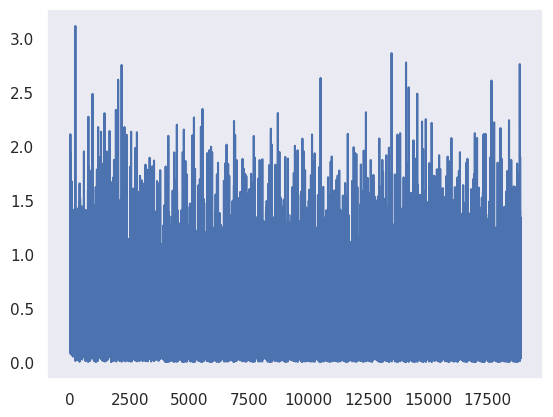

In [31]:
plt.plot(train_losses)

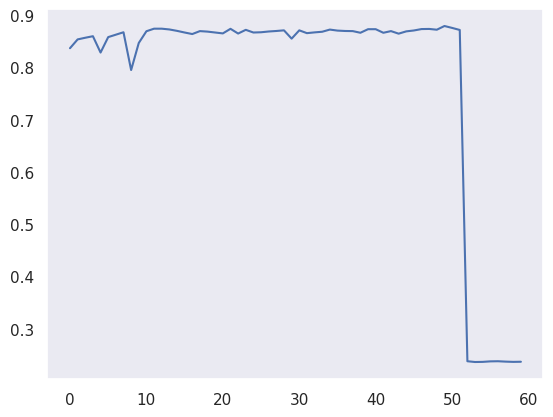

In [32]:
plt.plot(test_accuracy)

In [33]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 971/4064 (0.2389)
{'acc_detail': tensor([1., 0.], device='cuda:0'),
 'acc_unweighted': tensor(0.5000, device='cuda:0'),
 'acc_weighted': tensor(0.2389, device='cuda:0'),
 'f1s': tensor(0.1929, device='cuda:0'),
 'f1s_detail': tensor([0.3857, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2389, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0.], device='cuda:0'),
 'rocauc': tensor([0.4943, 0.5057], device='cuda:0'),
 'uar': tensor(0.5000, device='cuda:0'),
 'wap': tensor(0.0571, device='cuda:0')}


tensor([[ 971,    0],
        [3093,    0]], device='cuda:0')

In [34]:
model_path = '../physio16k_fold4_m13sinc_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [35]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
 

In [36]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

[None, None]

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6831: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6832: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

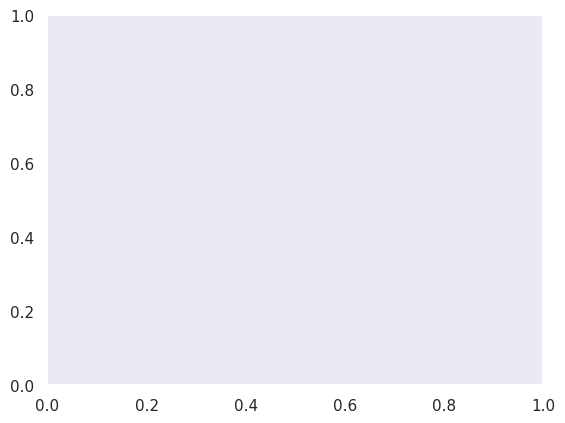

In [37]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

In [ ]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

In [ ]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [ ]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [ ]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

In [ ]:
named_params12 = [p for p in layer.named_parameters()]
lowbands12 = named_params12[0][1].detach().cpu().numpy()
plt.hist(lowbands12.flatten(), bins=40)

In [ ]:
lowbands12 = named_params12[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands12.flatten(), bins=40)

In [ ]:
bandwidths12 = named_params12[1][1].detach().cpu().numpy()
plt.hist(bandwidths12.flatten(), bins=40)

In [ ]:
bandwidths12 = named_params12[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths12.flatten(), bins=40)

In [ ]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

In [ ]:
named_params22 = [p for p in layer22.named_parameters()]
lowbands22 = named_params22[0][1].detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

In [ ]:
lowbands22 = named_params22[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

In [ ]:
bandwidth22 = named_params22[1][1].detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

In [ ]:
bandwidths22 = named_params22[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

In [ ]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

In [77]:
# del model
# gc.collect()

340729